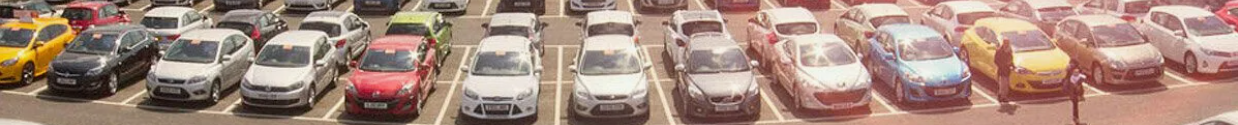

# Прогноз стоимости автомобиля на вторичном рынке

[Kaggle](https://www.kaggle.com/competitions/used-cars-price-prediction-yap17/overview)

**Описание задачи**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!\
Целью проекта будет разработанная модель предсказания стоимости (sellingprice) автомобиля на вторичном рынке.

**Данные**

`train.csv` - информация о продажах (\~440000) автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.\
`test.csv` - информация о продажах (\~110000) автомобилей с аукционов, которые будут использоваться в качестве тестовых данных. 
`sample_submission.csv` - файл предсказаний в правильном формате.

**Описание полей данных**

`year` - год производства\
`make` - производитель\
`model` - модель\
`trim` - модификация\
`body` - тип кузова\
`transmission` - тип КПП\
`vin` - идентификатор\
`state` - штат регистрации\
`condition` - состояние по шкале (1-5)\
`odometer` - пробег в милях\
`color` - цвет кузова\
`interior` - цвет интерьера\
`seller` - продавец\
`sellingprice` - стоимость продажи\
`saledate` - дата продажи

**Ход работы**
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

## загрузка и ознакомление с данными

In [1]:
!pip install vininfo -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import table
from vininfo import Vin
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [3]:
data                   = pd.read_csv('../../12 мастерская/train.csv')             # обучающие данные
data_test              = pd.read_csv('../../12 мастерская/test.csv')              # тестовые данные
data_sample_submission = pd.read_csv('../../12 мастерская/sample_submission.csv') # образец файла с предсказаниями

In [4]:
data.head(2)

year  make   model trim   body transmission                vin state  \
0  2011  Ford    Edge  SEL    suv    automatic  2fmdk3jc4bba41556    md   
1  2014  Ford  Fusion   SE  Sedan    automatic  3fa6p0h75er208976    mo   

   condition  odometer  color interior                 seller  sellingprice  \
0        4.2  111041.0  black    black     santander consumer         12500   
1        3.5   31034.0  black    black  ars/avis budget group         14500   

                                  saledate  
0  Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)  
1  Wed Feb 25 2015 02:00:00 GMT-0800 (PST)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [6]:
data.describe()

year      condition       odometer   sellingprice
count  440236.000000  430831.000000  440167.000000  440236.000000
mean     2010.040101       3.425077   68344.421604   13592.209588
std         3.977945       0.949973   53542.203908    9751.479098
min      1982.000000       1.000000       1.000000       1.000000
25%      2007.000000       2.700000   28258.000000    6900.000000
50%      2012.000000       3.600000   52098.000000   12100.000000
75%      2013.000000       4.200000   99272.000000   18200.000000
max      2015.000000       5.000000  999999.000000  230000.000000

In [7]:
# число уникальных значений в каждом признаке
for i in data:
    print(f'{i}_({data[i].nunique()}) ',end='')

year_(34) make_(92) model_(959) trim_(1922) body_(85) transmission_(2) vin_(440236) state_(38) condition_(41) odometer_(159364) color_(20) interior_(17) seller_(13025) sellingprice_(1735) saledate_(3597) 

In [8]:
data_test.head(2)

year      make         model  trim   body transmission                vin  \
0  2005  Cadillac           CTS  Base  Sedan    automatic  1g6dp567450124779   
1  2014       GMC  Savana Cargo  2500    Van          NaN  1gtw7fca7e1902207   

  state  condition  odometer   color interior                  seller  \
0    ca        2.7  116970.0  silver    black  lexus of stevens creek   
1    pa        4.4    6286.0   white     gray                  u-haul   

                                  saledate  
0  Wed Jan 14 2015 04:30:00 GMT-0800 (PST)  
1  Fri Feb 27 2015 01:00:00 GMT-0800 (PST)

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [10]:
data_test.describe()

year      condition       odometer
count  110060.000000  107681.000000  110041.000000
mean     2010.059904       3.423206   68075.693541
std         3.960432       0.951323   53523.551837
min      1982.000000       1.000000       1.000000
25%      2007.000000       2.700000   28314.000000
50%      2012.000000       3.600000   51922.000000
75%      2013.000000       4.200000   98854.000000
max      2015.000000       5.000000  999999.000000

In [11]:
data_sample_submission.head(2)

vin  sellingprice
0  1g6dp567450124779  13592.209588
1  1gtw7fca7e1902207  13592.209588

In [12]:
data_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110060 non-null  object 
 1   sellingprice  110060 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


Вывод по первичному ознакомлению: есть пропуски, saledate не в формате datetime. Изучим подробнее каждый признак.

Проверка на дубликаты:

In [13]:
data.duplicated().sum() # количество полных явных строк-дубликатов

0

In [14]:
data.drop('vin',axis=1).duplicated().sum() # количество полных явных строк-дубликатов без признака 'vin'

0

### создание новых признаков

In [15]:
for d in (data,data_test):
    d['saledate_dt']      = pd.to_datetime(d['saledate'].apply(lambda x: x[:15]),format='%a %b %d %Y') # дата прод. в datetime
    d['lifetime']         = d['saledate_dt'].dt.year-d['year']+1                                       # срок эксплуатации
    d['month']            = d['saledate_dt'].dt.month                                                  # месяц продажи
    d['weekday']          = d['saledate_dt'].dt.weekday                                                # день недели продажи
    d['saledate_unix']    = d['saledate_dt'].apply(lambda x: x.timestamp())                            # дата прод. в unix
    d['mileage_per_year'] = d['odometer']/d['lifetime']                                                # кол-во миль в год
    d['country']          = d['vin'].apply(lambda x: Vin(x).country)                                   # страна производитель

### пропуски

In [16]:
data_na = pd.DataFrame(data     .isna().sum(), columns=['count'])   .join(
          pd.DataFrame(data     .isna().mean(),columns=['share']))  .join(
          pd.DataFrame(data_test.isna().sum(), columns=['count_t'])).join(
          pd.DataFrame(data_test.isna().mean(),columns=['share_t']))
data_na.style.format({'share':'{:.2f}', 'share_t':'{:.2f}', 'count_t':'{:.2f}'}).background_gradient()

### year

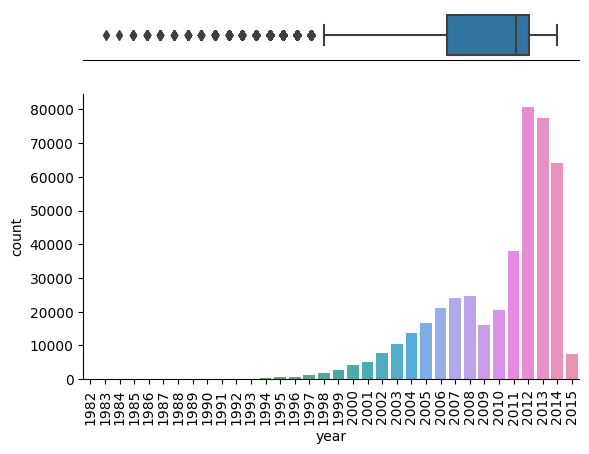

In [17]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['year'], ax=ax_1)
sns.countplot(x=data['year'], ax=ax_2)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Пропусков, дубликатов и выбросов нет. Распределение логичное. Спад производство автомобилей в 2009 году связан с экономическим кризисом. В 2009 году общий выпуск автомобилей в мире по сравнению с 2008 годом упал на 12,4 процента. В мировом масштабе кризис продолжался как минимум до 2011 года. [Статья в Коммерсант от 19.05.2020.](https://www.kommersant.ru/doc/4347780#:~:text=%D0%93%D0%BB%D0%BE%D0%B1%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D1%8D%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BA%D1%80%D0%B8%D0%B7%D0%B8%D1%81)

### saledate (_dt, _unix)

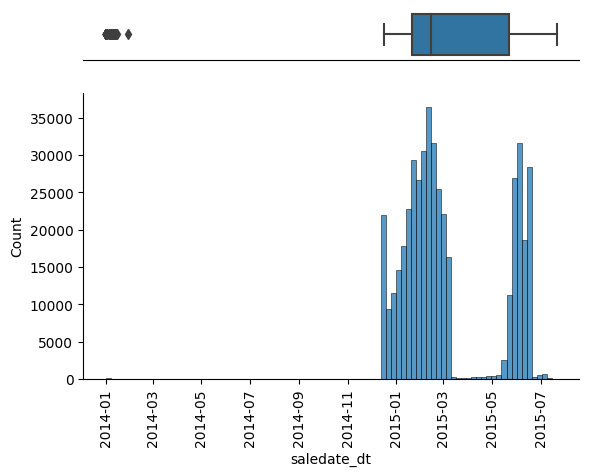

In [18]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['saledate_unix'], ax=ax_1)
sns.histplot(x=data['saledate_dt'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Основной массив данных в первом полугодии 2015-го года. Наблюдаем выбросы в 2014 году.

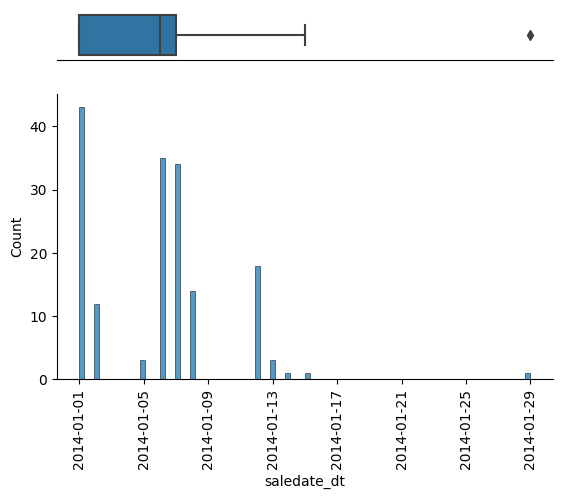

In [19]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['saledate_unix'][data['saledate_unix']<=pd.to_datetime("2014-12-15").timestamp()], ax=ax_1)
sns.histplot(x=data['saledate_dt'][data['saledate_dt']<='2014-12-15'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Основной массив данных начинается с 16.12.2014г. Выбросы в январе 2014г.

In [20]:
data.query("saledate_dt<='2014-12-15'").shape[0] # число выбросов в saledate

165

In [21]:
data.query("saledate_dt<='2014-12-15'").shape[0]/data.shape[0] # доля выбросов в saledate

0.00037479897146076196

Удаляем 165 объектов (0.03%), являющихся выбросом по saledate:

In [22]:
data.drop(data['saledate_dt'][data['saledate_dt']<='2014-12-15'].index, inplace=True)

Распределение после удаления выбросов:

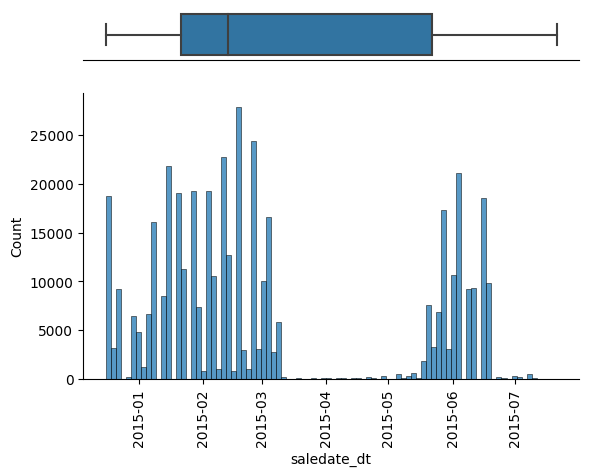

In [23]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['saledate_unix'], ax=ax_1)
sns.histplot(x=data['saledate_dt'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

🥝 **data_test** 🥝

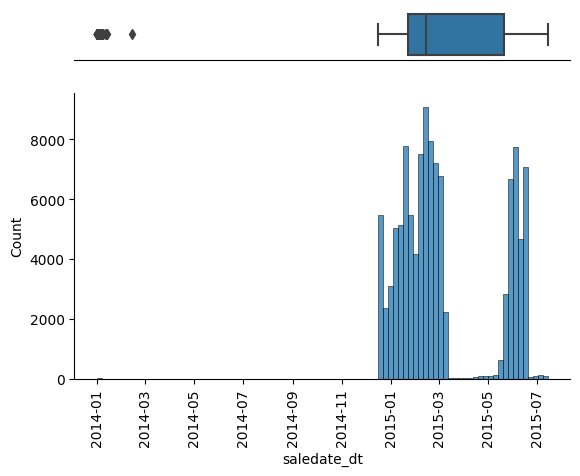

In [24]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data_test['saledate_unix'], ax=ax_1)
sns.histplot(x=data_test['saledate_dt'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

In [25]:
data_test.query("saledate_dt<='2014-12-15'").shape[0] # число выбросов в saledate

42

Видим в data_test такие же выбросы в начале 2014 г., как и в обучающем data. Удалять объекты из тестовой выборки не можем. Смещать на год позднее не будем. Количество мизерное, и, вероятно, дата не сильно сказывается на прогнозе.

### lifetime

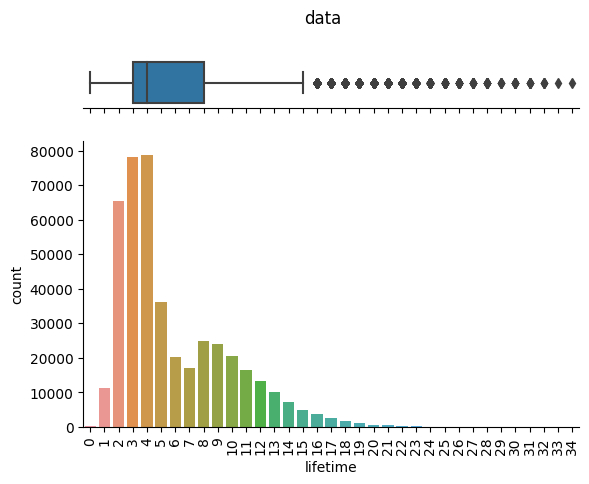

In [26]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['lifetime'], ax=ax_1)
sns.countplot(x=data['lifetime'], ax=ax_2)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90); f.suptitle('data'); plt.show()

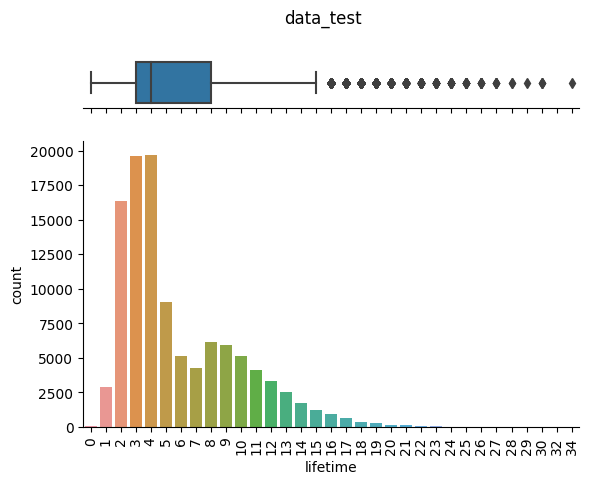

In [27]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data_test['lifetime'], ax=ax_1)
sns.countplot(x=data_test['lifetime'], ax=ax_2)
ax_1.set(yticks=[],xlabel=None); sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90); f.suptitle('data_test'); plt.show()

Видим наличие нулевых значений, чего быть не должно. Признак создавался, как разница года производства из года продажи + 1. Получается у каких-то объектов год продажи меньше года производства 🤷‍♂️\
Может быть ситуация, когда машина продаётся до момента выхода с конвейера - случай для рынка новых автомобилей; мы же исследуем вторичный рынок.

In [28]:
data.query('lifetime == 0').shape[0]      # кол-во объектов с нулевым сроком эксплуатации

162

In [29]:
data_test.query('lifetime == 0').shape[0] # кол-во объектов с нулевым сроком эксплуатации (тестовая выборка)

35

In [30]:
# описание данных, в которых год продажи  меньше года производства
data.query('lifetime == 0').drop(['mileage_per_year','saledate_unix','weekday','month'], axis=1).\
describe(datetime_is_numeric=True)

year   condition      odometer  sellingprice          saledate_dt  \
count   162.0  137.000000    162.000000    162.000000                  162   
mean   2015.0    4.043796  11031.141975  24897.839506  2014-12-22 19:06:40   
min    2015.0    1.000000     31.000000   3600.000000  2014-12-16 00:00:00   
25%    2015.0    3.700000   5667.000000  13375.000000  2014-12-18 00:00:00   
50%    2015.0    4.500000  10769.000000  21000.000000  2014-12-23 00:00:00   
75%    2015.0    4.900000  14814.250000  36650.000000  2014-12-30 00:00:00   
max    2015.0    5.000000  31043.000000  59900.000000  2014-12-31 00:00:00   
std       0.0    1.165929   6611.738974  14014.443912                  NaN   

       lifetime  
count     162.0  
mean        0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  
std         0.0

In [31]:
# описание данных, в которых год продажи  меньше года производства (тестовая выборка)
data_test.query('lifetime == 0').drop(['mileage_per_year','saledate_unix','weekday','month'], axis=1).\
describe(datetime_is_numeric=True)

year  condition      odometer                    saledate_dt  \
count    35.0  33.000000     35.000000                             35   
mean   2015.0   4.121212  11761.114286  2014-12-13 16:27:25.714285824   
min    2015.0   1.000000    519.000000            2014-01-06 00:00:00   
25%    2015.0   4.200000   5301.500000            2014-12-18 12:00:00   
50%    2015.0   4.600000  12730.000000            2014-12-23 00:00:00   
75%    2015.0   4.900000  16950.500000            2014-12-30 00:00:00   
max    2015.0   5.000000  29693.000000            2014-12-31 00:00:00   
std       0.0   1.232061   7199.062516                            NaN   

       lifetime  
count      35.0  
mean        0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  
std         0.0

Объекты с датой изготовления большей даты продажи реализованы в январе или декабре 2014. Километраж +/- соответствует годовому.\
Предположим, что в дате изготовления опечатка.<br> 
Исправим год на 2014 и пересчитаем срок эксплуатации с ежегодным пробегом:

In [32]:
for d in (data,data_test):
    d.loc[d['lifetime']==0,'year'] = 2014
    d['lifetime'] = d['saledate_dt'].dt.year-d['year']+1
    d['mileage_per_year']=d['odometer']/d['lifetime']

Медианное значение срока службы 4 года. Пропусков и выбросов нет. У 162 объектов 'year' в обучающей и в 35-ти объектах тестовой выборок уменьшен на год чтобы не был больше даты продажи.

### weekday

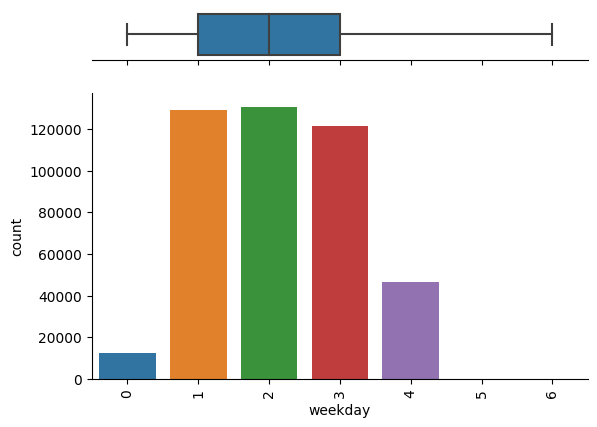

In [33]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['weekday'], ax=ax_1)
sns.countplot(x=data['weekday'], ax=ax_2)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Чаще всего автомобили продаются со вторника по четверг.

### mileage_per_year

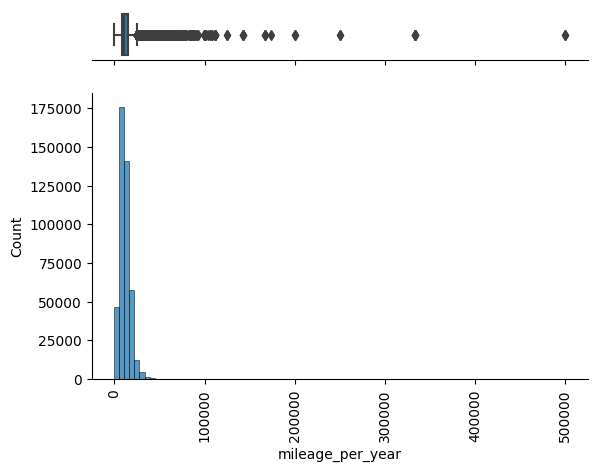

In [34]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['mileage_per_year'], ax=ax_1)
sns.histplot(x=data['mileage_per_year'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Ориентировочный максимальный пробег автомобиля (например, такси) 90 тыс.км в год (62137 миль). Информация с [DRIVE2.RU.](https://www.drive2.ru/b/549680223537332322/#:~:text=%D0%A3%20%D1%82%D0%B0%D0%BA%D1%81%D0%B8%20%D1%80%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B1%D0%B5%D0%B3%20%D0%B2%20%D0%B3%D0%BE%D0%B4%20%D0%BD%D0%B5%20%D0%BC%D0%B5%D0%BD%D0%B5%D0%B5%2060%20000%D0%BA%D0%BC%20%D0%B2%20%D0%B3%D0%BE%D0%B4%2C%20%D1%87%D0%B0%D1%89%D0%B5%2090%20000%D0%BA%D0%BC.) \
Посмотрим автомобили, у которых пробег выше прогнозного максимального:

In [35]:
data.query('mileage_per_year > 62137').describe(datetime_is_numeric=True).drop(['saledate_unix','weekday','month'], axis=1)

year   condition       odometer  sellingprice  \
count   122.000000  120.000000     122.000000    122.000000   
mean   2010.286885    2.600833  529631.672131   7403.688525   
min    2001.000000    1.000000   62224.000000    100.000000   
25%    2007.250000    1.900000  150651.500000   1662.500000   
50%    2012.000000    2.300000  375186.000000   4250.000000   
75%    2014.000000    3.700000  999999.000000  12700.000000   
max    2015.000000    5.000000  999999.000000  44750.000000   
std       3.934336    1.190261  407943.972587   7280.025934   

                         saledate_dt    lifetime  mileage_per_year  
count                            122  122.000000        122.000000  
mean   2015-02-06 09:14:45.245901568    5.270492     105462.505523  
min              2014-12-16 00:00:00    1.000000      62224.000000  
25%              2014-12-30 00:00:00    2.000000      65945.500000  
50%              2015-01-12 12:00:00    4.000000      76923.000000  
75%              2015-02-25 12:00:00    8.750000     102636.750000  
max              2015-07-07 00:00:00   15.000000     499999.500000  
std                              NaN    4.150151      78905.437858

Количество автомобилей с подозрительно высоким километражом 122 шт. (0.03%).\
Удалим данные объекты, как выбросы неимеющие статистической значимости:

In [36]:
data.drop(data.query('mileage_per_year > 62137').index,inplace=True)

Распределение после удаления выбросов:

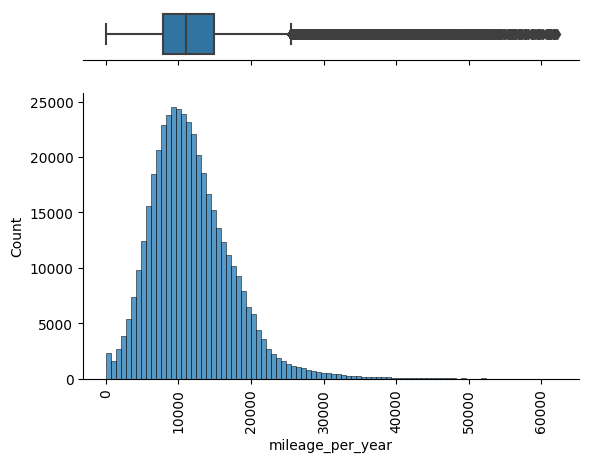

In [37]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['mileage_per_year'], ax=ax_1)
sns.histplot(x=data['mileage_per_year'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Нормальное распределение, скошенное вправо.

🥝 **data_test** 🥝

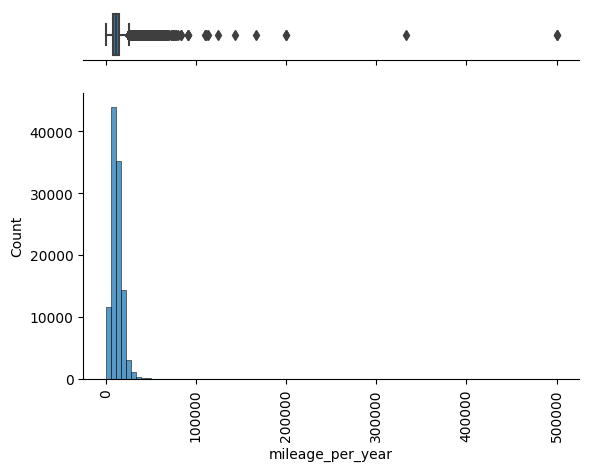

In [38]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data_test['mileage_per_year'], ax=ax_1)
sns.histplot(x=data_test['mileage_per_year'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

In [39]:
data_test.query('mileage_per_year > 62137').describe(datetime_is_numeric=True).drop(['saledate_unix','weekday','month'], axis=1)

year  condition       odometer                    saledate_dt  \
count    43.000000  42.000000      43.000000                             43   
mean   2010.558140   2.364286  520961.720930  2015-02-20 22:19:32.093023232   
min    2001.000000   1.000000   62407.000000            2014-12-16 00:00:00   
25%    2008.500000   1.900000  147583.500000            2014-12-31 00:00:00   
50%    2012.000000   2.050000  419894.000000            2015-01-22 00:00:00   
75%    2014.000000   3.150000  999999.000000            2015-04-12 12:00:00   
max    2014.000000   4.500000  999999.000000            2015-06-18 00:00:00   
std       3.929754   1.087360  396711.574435                            NaN   

        lifetime  mileage_per_year  
count  43.000000         43.000000  
mean    5.162791     112944.853885  
min     1.000000      62318.166667  
25%     2.000000      66539.800000  
50%     4.000000      75367.500000  
75%     7.500000     110591.250000  
max    15.000000     499999.500000  
std     4.122703     100090.595792

Кол-во объектов с аномально завышенным пробегом 43. Удалять объекты из тестовой выборки мы не можем. <br> Исправим пробег из расчёта предполагаемого максимального в год (62137 миль):

In [40]:
data_test.loc[data_test['mileage_per_year'] > 62137,'mileage_per_year']       = 62137
data_test.loc[data_test['odometer'] > 62137*data_test['lifetime'],'odometer'] = 62137*data_test['lifetime']

### odometer

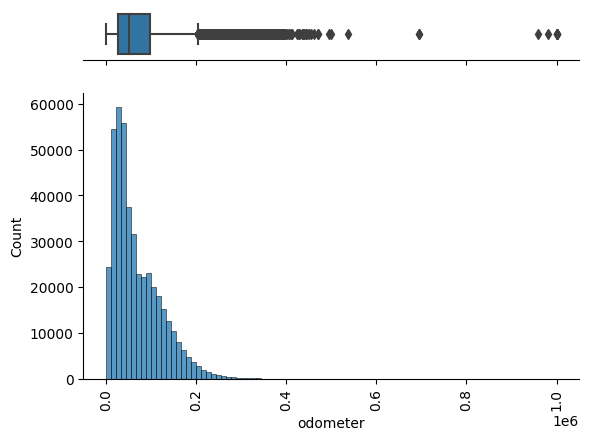

In [41]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['odometer'], ax=ax_1)
sns.histplot(x=data['odometer'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Описание объектов с пробегом более 400 тыс. миль:

In [42]:
data.query('odometer>0.4*10**6').describe(datetime_is_numeric=True).drop(['saledate_unix','weekday','month'], axis=1)

year  condition       odometer  sellingprice  \
count    32.000000  28.000000      32.000000     32.000000   
mean   2001.937500   2.017857  580306.375000   2097.656250   
min    1993.000000   1.000000  402934.000000    200.000000   
25%    1999.000000   1.900000  429531.250000    500.000000   
50%    2002.000000   1.900000  453822.500000   1000.000000   
75%    2005.250000   2.075000  694978.000000   1925.000000   
max    2008.000000   4.700000  999999.000000   9000.000000   
std       4.295065   0.757703  231009.439215   2571.590754   

               saledate_dt   lifetime  mileage_per_year  
count                   32  32.000000         32.000000  
mean   2015-03-07 21:45:00  13.906250      42750.047772  
min    2014-12-17 00:00:00   8.000000      22889.526316  
25%    2015-02-06 12:00:00  10.500000      32536.589286  
50%    2015-02-17 12:00:00  13.500000      43153.381423  
75%    2015-05-09 18:00:00  17.000000      53451.242788  
max    2015-06-16 00:00:00  23.000000      59703.777778  
std                    NaN   4.328148      11644.719096

В данных 32 объекта с пробегом более 400 тыс. миль (644 тыс.км). Описание правдоподобно. Удалять не будем.

In [43]:
data['odometer'].median().round() # медианный пробег в милях

52092.0

In [44]:
(data['odometer'].median()*1.609).round() # медианный пробег в км

83816.0

Описание объектов с пробегом менее 10 миль и сроком службы более года:

In [45]:
data.query('odometer < 10 & lifetime > 1').describe(datetime_is_numeric=True).drop(['saledate_unix','weekday','month'], axis=1)

year    condition     odometer  sellingprice  \
count  1082.000000  1008.000000  1082.000000   1082.000000   
mean   2004.263401     2.062302     1.196858   2985.297597   
min    1990.000000     1.000000     1.000000      1.000000   
25%    2001.000000     1.200000     1.000000    500.000000   
50%    2004.000000     2.000000     1.000000   1175.000000   
75%    2007.000000     2.400000     1.000000   3000.000000   
max    2014.000000     5.000000     9.000000  65500.000000   
std       4.818628     0.917808     1.066290   5406.301674   

                         saledate_dt     lifetime  mileage_per_year  
count                           1082  1082.000000       1082.000000  
mean   2015-02-21 01:43:48.465804032    11.574861          0.218150  
min              2014-12-16 00:00:00     2.000000          0.038462  
25%              2015-01-13 00:00:00     9.000000          0.066667  
50%              2015-02-04 00:00:00    12.000000          0.083333  
75%              2015-03-10 00:00:00    15.000000          0.111111  
max              2015-07-21 00:00:00    26.000000          4.500000  
std                              NaN     4.796742          0.600078

Более 1000 объектов с подозрительно низким пробегом. У большинства проставлена 1. <br>
Судя по медиане у данных объектов плохое техническое состояние и большой срок службы.
Заполним данные ячейки с пробегом медианными значениями, стратифицированными по сроку службы:

In [46]:
for i in data['lifetime'].unique():
    data.loc[  (data['odometer'] < 10) & (data['lifetime'] > 1)  & (data['lifetime'] == i),'odometer'] = \
    data.loc[~((data['odometer'] < 10) & (data['lifetime'] > 1)) & (data['lifetime'] == i),'odometer'].median()

Объекты с пропусками в количестве 67 шт (0.02%) удаляем:

In [47]:
data.drop(data.query('odometer.isna()').index, inplace=True)

🥝 **data_test** 🥝

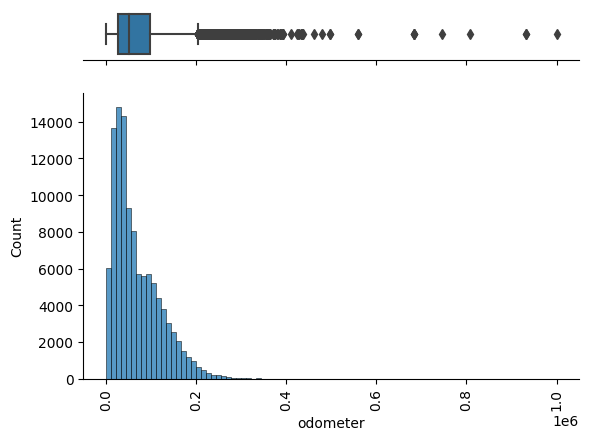

In [48]:
f, (ax_1, ax_2) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data_test['odometer'], ax=ax_1)
sns.histplot(x=data_test['odometer'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Описание объектов с пробегом более 400 тыс. миль:

In [49]:
data_test.query('odometer>0.4*10**6').describe(datetime_is_numeric=True).drop(['saledate_unix','weekday','month'], axis=1)

year  condition       odometer          saledate_dt   lifetime  \
count    23.000000  23.000000      23.000000                   23  23.000000   
mean   2004.391304   1.978261  582220.956522  2015-03-05 00:00:00  11.608696   
min    1996.000000   1.000000  411053.000000  2015-01-08 00:00:00   7.000000   
25%    2001.000000   1.450000  434959.000000  2015-01-20 12:00:00   8.500000   
50%    2005.000000   1.900000  497096.000000  2015-02-05 00:00:00  11.000000   
75%    2007.500000   2.600000  683507.000000  2015-04-13 00:00:00  15.000000   
max    2009.000000   3.500000  999999.000000  2015-06-17 00:00:00  20.000000   
std       3.786809   0.729855  188031.892608                  NaN   3.786809   

       mileage_per_year  
count         23.000000  
mean       52826.038114  
min        24968.764706  
25%        45735.850000  
50%        62137.000000  
75%        62137.000000  
max        62137.000000  
std        14132.680239

В данных 23 объектах с пробегом более 400 тыс. миль (644 тыс.км) описание правдоподобно.

In [50]:
data_test['odometer'].median().round()         # медианный пробег в милях

51922.0

In [51]:
(data_test['odometer'].median()*1.609).round() # медианный пробег в км

83542.0

Описание объектов с пробегом менее 10 миль и сроком службы более года:

In [52]:
data_test.query('odometer < 10 & lifetime > 1').describe(datetime_is_numeric=True).\
                                                         drop(['saledate_unix','weekday','month'], axis=1)

year   condition    odometer                 saledate_dt  \
count   256.000000  233.000000  256.000000                         256   
mean   2004.191406    2.103433    1.210938  2015-02-15 00:39:22.500000   
min    1990.000000    1.000000    1.000000         2014-12-17 00:00:00   
25%    2001.000000    1.900000    1.000000         2015-01-07 00:00:00   
50%    2004.000000    2.000000    1.000000         2015-01-28 00:00:00   
75%    2007.000000    2.300000    1.000000         2015-03-03 06:00:00   
max    2014.000000    5.000000    9.000000         2015-07-09 00:00:00   
std       4.545897    0.868255    1.078505                         NaN   

         lifetime  mileage_per_year  
count  256.000000        256.000000  
mean    11.617188          0.207738  
min      2.000000          0.040000  
25%      9.000000          0.066667  
50%     12.000000          0.083333  
75%     15.000000          0.111111  
max     25.000000          4.500000  
std      4.526386          0.571701

256 объектов с подозрительно низким пробегом. У большинства проставлена 1. <br>
Судя по медиане у данных объектов плохое техническое состояние и большой срок службы.
Заполним данные ячейки с пробегом медианными значениями, стратифицированными по сроку службы:

In [53]:
for i in data_test['lifetime'].unique():
    data_test.loc[  (data_test['odometer'] < 10) & (data_test['lifetime'] > 1) & (data_test['lifetime'] == i),'odometer'] = \
    data_test.loc[~((data_test['odometer'] < 10) & (data_test['lifetime'] > 1)) & (data_test['lifetime'] == i),'odometer'].\
                                                                                                                    median()

Ячейки с 19-ю пропусками также заполним медианными значениями, стратифицированными по сроку службы:

In [54]:
for i in data_test['lifetime'].unique():
    data_test.loc[(data_test['odometer'].isna()) & (data_test['lifetime'] == i),'odometer'] = \
                                      data_test.loc[data_test['lifetime'] == i, 'odometer'].median()

In [55]:
# т.к. появились новые значения в odometer можем дозаполнить mileage_per_year
data_test.loc[data_test['mileage_per_year'].isna(),'mileage_per_year'] = data_test['odometer']/data_test['lifetime']

### condition

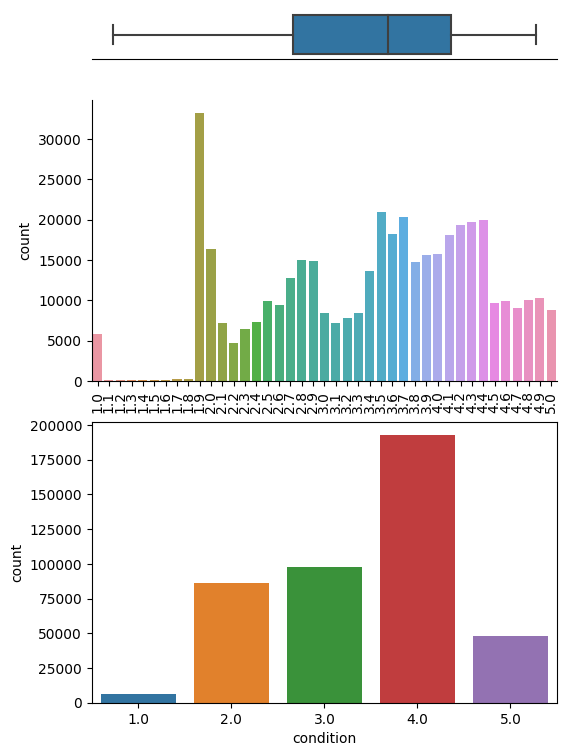

In [56]:
f, (ax_1, ax_2, ax_3) = plt.subplots(3, gridspec_kw={"height_ratios": (.15, .85, 0.85)},figsize=(6,9))
sns.boxplot(x=data['condition'], ax=ax_1)
sns.countplot(x=data['condition'], ax=ax_2)
sns.countplot(x=data['condition'].round(), ax=ax_3)
ax_1.set(yticks=[],xticks=[],xlabel=None); ax_2.set(xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

Распределение в крупном округлённом масштабе понятное логичное; в детальном исходном масштабе видим резкий спад от 1.1 до 1.8. 

In [57]:
# кол-во уникальных значений в подозрительном диапазоне
data.query('0 < condition < 2')['condition'].value_counts().sort_index()

1.0     5826
1.1       74
1.2       74
1.3       68
1.4      103
1.5      122
1.6      131
1.7      198
1.8      248
1.9    33176
Name: condition, dtype: int64

Причина спада в данном диапазоне не ясна; вероятно, связано с алгоритмом расчёта метрики.\
Выбросы не обнаружены.

Пропуски в количестве 9354 шт. (2%) на обучающей выборке и 2379 шт. (2%) на тестовой заполняем медианными значениями, стратифицированными по пробегу. <br>
До 300 тыс.миль диапазон по 10 тыс. От 300 тыс. до максимума 999999 - 1 диапазон.

In [58]:
for d in (data,data_test):
    i_last = 0
    for i in list(range(10**4,300000+1,10**4))+[10**6]:
        d.loc[(d['condition'].isna()) & (i_last<d['odometer']) & (d['odometer']<=i),'condition'] = \
                                  d.loc[(i_last<d['odometer']) & (d['odometer']<=i),'condition'].median()
        i_last = i

### sellingprice

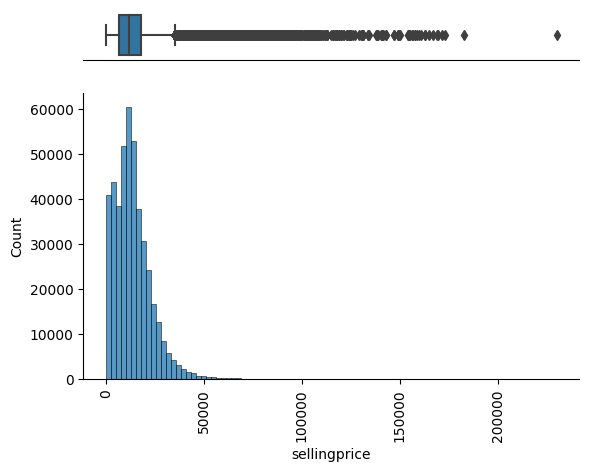

In [59]:
f, (ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=data['sellingprice'], ax=ax_1)
sns.histplot(x=data['sellingprice'], ax=ax_2, bins=90)
ax_1.set(yticks=[],xticks=[],xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis='x',labelrotation=90)

In [60]:
data.query('sellingprice > 100000')['make'].value_counts() # марки автомобилей дороже 100 тыс.

Mercedes-Benz    29
Bentley          21
Ferrari          16
Land Rover       15
BMW              14
Rolls-Royce      14
Audi             13
Porsche           6
Lamborghini       4
Aston Martin      1
Ford              1
Name: make, dtype: int64

In [61]:
data.sort_values(by='sellingprice',ascending=False).head(3) # топ объектов с максимальной ценой

year           make       model      trim   body transmission  \
392004  2014           Ford      Escape  Titanium    SUV    automatic   
423302  2011        Ferrari  458 Italia      Base  coupe    automatic   
359111  2015  Mercedes-Benz     S-Class   S65 AMG  Sedan    automatic   

                      vin state  condition  odometer  ...  \
392004  1fmcu9j98eua23833    mo        4.3   27802.0  ...   
423302  zff67nfa1b0178698    fl        4.6   12116.0  ...   
359111  wddug7kb2fa102347    ca        4.1    5277.0  ...   

                             seller sellingprice  \
392004  ford-lincoln dealer program       230000   
423302          platinum motor cars       183000   
359111            mercedes-benz usa       173000   

                                       saledate  saledate_dt lifetime month  \
392004  Wed Feb 25 2015 02:00:00 GMT-0800 (PST)   2015-02-25        2     2   
423302  Wed Jun 17 2015 03:40:00 GMT-0700 (PDT)   2015-06-17        5     6   
359111  Thu May 21 2015 05:00:00 GMT-0700 (PDT)   2015-05-21        1     5   

        weekday  saledate_unix  mileage_per_year        country  
392004        2   1.424822e+09           13901.0  United States  
423302        2   1.434499e+09            2423.2          Italy  
359111        3   1.432166e+09            5277.0        Germany  

[3 rows x 22 columns]

Новый Ford Escape Titanium стоит от $37000 ([Сайт Ford](https://www.ford.com/suvs-crossovers/escape/2022/models/escape-titanium/)). Вероятно, в цене десятикратная ошибка. Исправим:

In [62]:
data.loc[392004,'sellingprice'] /= 10 

Остальные автомобили с ценой более 100 тыс. принадлежат премиальным маркам и такая стоимость может быть.

In [63]:
data.sort_values(by='sellingprice').head() # топ объектов с минимальной ценой

year           make     model  trim     body transmission  \
137962  2003  Mercedes-Benz   E-Class  E500    Sedan    automatic   
18762   2002           Ford    Taurus   SES    sedan          NaN   
90212   2006           Ford  Freestar    SE  Minivan    automatic   
413415  1997     Mitsubishi    Galant    ES    Sedan    automatic   
368828  2004        Pontiac   Montana  Base  Minivan    automatic   

                      vin state  condition  odometer  ...  \
137962  wdbuf70j73a269529    ga        2.1  138204.0  ...   
18762   1fafp55222a271061    pa        1.9  132230.0  ...   
90212   2fmza51656ba16153    hi        1.8   75389.0  ...   
413415  4a3aj56g1ve148491    ca        1.0  226034.0  ...   
368828  1gmdu03e74d147553    hi        2.0  106495.0  ...   

                             seller sellingprice  \
137962   peoples credit company inc          1.0   
18762             hertz remarketing        100.0   
90212   wells fargo dealer services        100.0   
413415                melody toyota        100.0   
368828          first hawaiian bank        100.0   

                                       saledate  saledate_dt lifetime month  \
137962  Tue Jan 06 2015 09:30:00 GMT-0800 (PST)   2015-01-06       13     1   
18762   Fri Jun 05 2015 02:00:00 GMT-0700 (PDT)   2015-06-05       14     6   
90212   Tue Mar 03 2015 16:00:00 GMT-0800 (PST)   2015-03-03       10     3   
413415  Wed Feb 04 2015 07:10:00 GMT-0800 (PST)   2015-02-04       19     2   
368828  Wed Jan 28 2015 06:30:00 GMT-0800 (PST)   2015-01-28       12     1   

        weekday  saledate_unix  mileage_per_year        country  
137962        1   1.420502e+09          0.076923        Germany  
18762         4   1.433462e+09       9445.000000  United States  
90212         1   1.425341e+09       7538.900000         Canada  
413415        2   1.423008e+09      11896.526316  United States  
368828        2   1.422403e+09       8874.583333  United States  

[5 rows x 22 columns]

Самый дешёвый 1 объект за 1 доллар.  Такие формальные сделки могли быть, тем более с 13-тилетними машинами. <br>
Тем не менее удалим этот объект - он двукратно отличаются от следующей минимальной цены $100:

In [64]:
data.drop(137962,inplace=True)

### make

In [65]:
def get_manufacturer(x):
    '''определяет производителя по vin'''
    try:
        return Vin(x).manufacturer
    except:
        pass

In [66]:
# заполняем пропущенные значения
for d in (data, data_test):
    d.loc[d['make'].isna(),'make'] = \
    d[d['make'].isna()].apply(lambda x: get_manufacturer(x['vin']),axis=1)

In [67]:
np.sort(data['make'][~data['make'].isna()].unique()) # уникальные значения

array(['AM', 'Acura', 'Aston Martin', 'Audi', 'BMW', 'BMW M', 'Bentley',
       'Buick', 'CAMI', 'Cadillac', 'Chevrolet', 'Chevrolet Canada',
       'Chevrolet Mexico', 'Chevrolet USA', 'Chrysler', 'Chrysler Canada',
       'Daewoo', 'Daimler AG (Sprinter)', 'DaimlerChrysler AG/Daimler AG',
       'Dodge', 'Dodge Canada', 'Dodge Mexico', 'FIAT', 'Ferrari', 'Fiat',
       'Fisker', 'Ford', 'GMC', 'GMC Truck', 'Genesis', 'Geo', 'HUMMER',
       'Honda', 'Hummer', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar',
       'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln',
       'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz',
       'Mercedes-Benz (Sprinter)', 'Mercury', 'Mitsubishi', 'Nissan',
       'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Porsche SUV',
       'Porsche car', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion',
       'Smart', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'UnsupportedBrand',
       'Volkswagen', 'Volkswagen Commercial Vehicles', 'Volvo', 'acura',
       'a

In [68]:
np.sort(data['make'][~data['make'].isna()].unique()).shape[0] # кол-во уникальных значений (обучающая выборка)

113

In [69]:
np.sort(data_test['make'][~data_test['make'].isna()].unique()).shape[0] # кол-во уникальных значений (тестовая выборка)

99

In [70]:
for d in (data, data_test):               # переписываем производителей в нижний регистр (убираем неявные дубликаты)
    d['make'] = d['make'].str.lower()

In [71]:
# убираем оставшиеся неявные дубликаты
for d in (data,data_test):
    d.loc[d['make']=='dodge tk','make']                       = 'dodge'
    d.loc[d['make']=='dot','make']                            = 'dodge'
    d.loc[d['make']=='dodge canada','make']                   = 'dodge'
    d.loc[d['make']=='dodge mexico','make']                   = 'dodge'
    d.loc[d['make']=='ford truck','make']                     = 'ford'
    d.loc[d['make']=='ford tk','make']                        = 'ford'
    d.loc[d['make']=='gmc truck','make']                      = 'gmc'
    d.loc[d['make']=='landrover','make']                      = 'land rover'
    d.loc[d['make']=='mazda tk','make']                       = 'mazda'
    d.loc[d['make']=='mercedes-b','make']                     = 'mercedes'
    d.loc[d['make']=='mercedes-benz','make']                  = 'mercedes'
    d.loc[d['make']=='daimler ag (sprinter)','make']          = 'mercedes'
    d.loc[d['make']=='daimlerchrysler ag/daimler ag','make']  = 'mercedes'
    d.loc[d['make']=='mercedes-benz (sprinter)','make']       = 'mercedes'
    d.loc[d['make']=='vw','make']                             = 'volkswagen'
    d.loc[d['make']=='volkswagen commercial vehicles','make'] = 'volkswagen'
    d.loc[d['make']=='am','make']                             = 'hummer'
    d.loc[d['make']=='bmw m','make']                          = 'bmw'
    d.loc[d['make']=='cami','make']                           = 'chevrolet'
    d.loc[d['make']=='chevrolet canada','make']               = 'chevrolet'
    d.loc[d['make']=='chevrolet mexico','make']               = 'chevrolet'
    d.loc[d['make']=='chevrolet usa','make']                  = 'chevrolet'
    d.loc[d['make']=='chev truck','make']                     = 'chevrolet'
    d.loc[d['make']=='chrysler canada','make']                = 'chrysler'
    d.loc[d['make']=='porsche car','make']                    = 'porsche'
    d.loc[d['make']=='porsche suv','make']                    = 'porsche'
    d.loc[d['make']=='hyundai tk','make']                     = 'hyundai'
    d.loc[d['make']=='lexus canada','make']                   = 'lexus'

In [72]:
# заполнение пропусков информацией из открытых источников
data.loc[49873, 'make'] = 'pontiac'
data.loc[135784,'make'] = 'buick'
data.loc[141702,'make'] = 'buick'
data.loc[369258,'make'] = 'jeep'

In [73]:
np.sort(data['make'][~data['make'].isna()].unique()) # уникальные значения после обработки (обучающая выборка)

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'ferrari', 'fiat', 'fisker', 'ford', 'genesis', 'geo', 'gmc',
       'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar',
       'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mercedes', 'mercury', 'mini', 'mitsubishi',
       'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [74]:
np.sort(data_test['make'][~data_test['make'].isna()].unique()) # уникальные значения после обработки (тестовая выборка)

array(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick',
       'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'ferrari',
       'fiat', 'fisker', 'ford', 'genesis', 'geo', 'gmc', 'honda',
       'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'land rover', 'lexus', 'lincoln', 'lotus', 'maserati', 'mazda',
       'mercedes', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [75]:
for d in (data, data_test):   # кол-во уникальных значений после обработки   (обучающая / тестовая)
    print (np.sort(d['make'][~d['make'].isna()].unique()).shape[0])

54
53


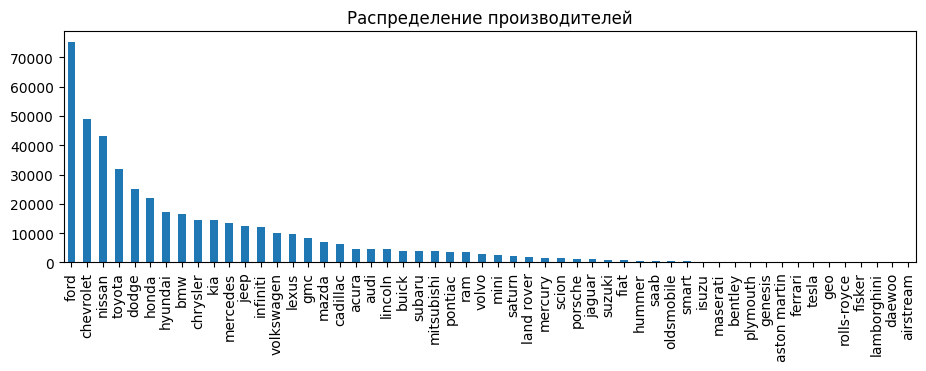

In [76]:
data['make'].value_counts().plot(kind='bar',figsize=(11,3),title='Распределение производителей'); plt.show()

Сократили число неявных дубликатов в ~2 раза. Заполнили пропуски с помощью модуля vininfo и открытых данных в сети.

### model

In [77]:
def get_model(x):
    '''определяет модель по vin'''
    try:
        return Vin(x).details.model.name
    except:
        pass

In [78]:
# заполняем пропущенные значения из модуля vininfo (если по позиции есть информация в модуле)
for d in (data, data_test):
    d.loc[d['model'].isna(),'model'] = \
    d[d['model'].isna()].apply(lambda x: get_model(x['vin']),axis=1)

In [79]:
# в ячейках списки преобразовываем в строки
for d in (data, data_test):
    d.loc[d['model'].apply(lambda x: type(x)==list),'model'] = \
    d.loc[d['model'].apply(lambda x: type(x)==list),'model'].apply(lambda y: ','.join(y))

In [80]:
# кол-во уникальных значений  (обучающая / тестовая)
for d in (data, data_test):
    print(np.sort(d['model'][~d['model'].isna()].unique()).shape[0])

962
826


In [81]:
# переписываем модели в нижний регистр и убираем пробелы по краям (при наличии)
for d in (data, data_test):
    d['model'] = d['model'].str.lower().str.strip()

In [82]:
# кол-во уникальных значений после обработки (обучающая / тестовая)
for d in (data, data_test):
    print(np.sort(d['model'][~d['model'].isna()].unique()).shape[0])

842
748


Пропусков около 2%, заполним 'unknown':

In [83]:
for d in (data, data_test):
    d['model'].fillna('unknown',inplace=True)

Уменьшил число уникальных значений на 12% и 9% в обучающей, тестовой выборках соответственно. Пропуски в кол-ве 2% заполнил 'unknown'.

### trim

In [84]:
# кол-во уникальных значений (обучающая / тестовая)
for d in (data, data_test):
    print(np.sort(d['trim'][~d['trim'].isna()].unique()).shape[0])

1922
1496


In [85]:
# убираем неявный дубликат
for d in (data, data_test):
    d.loc[d['trim'] == 'EX V6', 'trim'] = 'EX V-6'

In [86]:
# переписываем модификацию в нижний регистр и убираем пробелы по краям (при наличии)
for d in (data, data_test):
    d['trim'] = d['trim'].str.lower().str.strip()

In [87]:
# кол-во уникальных значений после обработки (обучающая / тестовая)
for d in (data, data_test):
    print(np.sort(d['trim'][~d['trim'].isna()].unique()).shape[0])

1839
1447


In [88]:
for d in (data, data_test):                       # доля модификаций в датасетах, которых больше 10 шт. (обучающий, тестовый)
    print ((d['trim'].value_counts()>=10).mean())

0.5367047308319739
0.3711126468555632


Модификации, которых менее 10 шт. переименуем в 'other':

In [89]:
trim_10 = data['trim'].value_counts()[data['trim'].value_counts()<10].index # перечень модификаций, которых менее 10 шт.

In [90]:
for d in (data, data_test):  
    d.loc[d['trim'].isin(trim_10),'trim'] = 'other'

In [91]:
# кол-во уникальных значений после второй обработки с заменой на other (обучающая / тестовая)
for d in (data, data_test):
    print(d['trim'][~d['trim'].isna()].unique().shape[0])

988
1023


Пропусков около 2%, заполним 'unknown':

In [92]:
for d in (data, data_test):
    d['trim'].fillna('unknown',inplace=True)

Визуально определил 1 дубликат, исправил.   Также с помощью перевода значений в нижний регистр и удаления пробелов по краям уменьшил число уникальных значений в обучающей и тестовой выборках соответсвенно на 4% и 3%.<br> 
Модификации с числом значений в обучающем датасете менее 10 шт. переименовал в 'other'. Их было около половины от общего числа уникальных значений. Таким образом, в итоге число уникальных значений в обучающей и тестовой выборках уменьшилось соответсвенно на 49% и 29%.<br> 
По остальным значениям сложно сказать является ли значение дубликатом. Например: 'Arc', 'Arc 2.3T', 'Arc 3.0t'. Есть базис 'Arc', и есть значения с уточнениями. Определить 'Arc' к одному или второму уточнению затруднительно. Все три значения преобразовать в 'Arc' - может отрицательно сказаться на качестве прогноза из-за сокращения вариций признака.  Таких примеров множество. Оставляем без изменений.\
Пропуски в кол-ве 2% заполнил 'unknown'.

### body

In [93]:
np.sort(data['body'][~data['body'].isna()].unique()) # уникальные значения

array(['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon',
       'CTS-V Coupe', 'CTS-V Wagon', 'Cab Plus', 'Cab Plus 4', 'Club Cab',
       'Convertible', 'Coupe', 'Crew Cab', 'CrewMax Cab', 'Double Cab',
       'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible',
       'G Coupe', 'G Sedan', 'G37 Convertible', 'G37 Coupe',
       'Genesis Coupe', 'GranTurismo Convertible', 'Hatchback',
       'King Cab', 'Koup', 'Mega Cab', 'Minivan', 'Promaster Cargo Van',
       'Q60 Convertible', 'Q60 Coupe', 'Quad Cab', 'Ram Van',
       'Regular Cab', 'SUV', 'Sedan', 'SuperCab', 'SuperCrew',
       'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon', 'Xtracab',
       'access cab', 'beetle convertible', 'cab plus 4', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe',
       'extended cab', 'g convertible', 'g coupe', 'g sedan',
       'g37 convertible', 'g37 coupe', 'genesis c

In [94]:
for d in (data, data_test):         # кол-во уникальных значений (обучающая / тестовая)
    print(d['body'][~d['body'].isna()].nunique())

85
77


In [95]:
# переписываем тип кузова в нижний регистр и убираем пробелы по краям (при наличии)
for d in (data, data_test):
    d['body'] = d['body'].str.lower().str.strip()  

In [96]:
for d in (data, data_test):                   # кол-во уникальных значений (обучающая / тестовая)
    print(d['body'][~d['body'].isna()].nunique())

45
42


Пропусков около 2%, заполним 'unknown':

In [97]:
for d in (data, data_test):
    d['body'].fillna('unknown',inplace=True)

C помощью перевода значений в нижний регистр и удаления пробелов по краям уменьшил число уникальных значений в обучающей и тестовой выборках соответсвенно на 48% и 46%.\
Проверил, есть ли в модуле vininfo значения body, отсутствующие в исходных данных задачи. Нет.\
Пропуски в кол-ве 2% заполнил 'unknown'.

### country

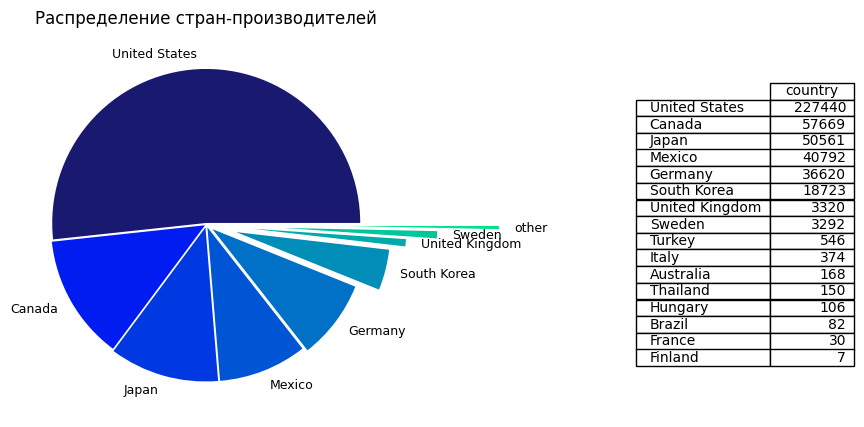

In [98]:
f, (ax_1, ax_2) = plt.subplots(1,2,gridspec_kw={"width_ratios": (6, 4)}, figsize=(10,5))

c = data['country'].value_counts()
pd.concat([c[c>=1000], pd.Series([c[c<1000].sum()],['other'])]).\
plot(kind='pie',label='',title='Распределение стран-производителей',
     explode = (0.01,0.01,0.02,0.02,0.05,0.2,0.3,0.5,0.9), ax=ax_1,
     colors = ['#191970', '#001CF0', '#0038E2', '#0055D4', '#0071C6', '#008DB8', '#00AAAA', '#00C69C', '#00E28E', '#00FF80'],
     fontsize = 9)
table(data=c, ax=ax_2, loc='right',colWidths=[0.3])
plt.axis('off'); plt.show()

### state

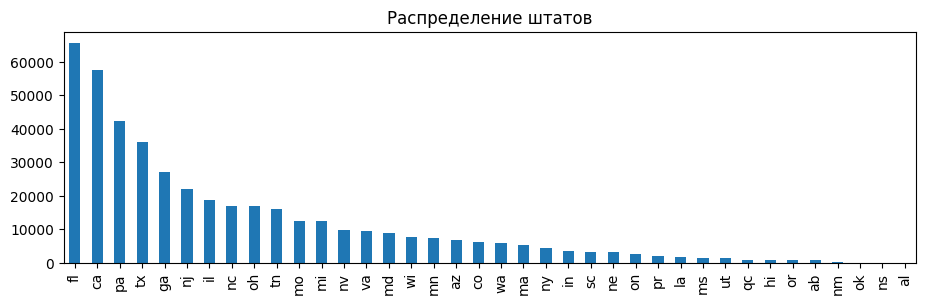

In [99]:
data['state'].value_counts().plot(kind='bar',figsize=(11,3),title='Распределение штатов'); plt.show()

Дубликатов и пропусков нет. Топ штатов, где совершаются регистрации: Флорида, Калифорния, Пенсильвания.

### color

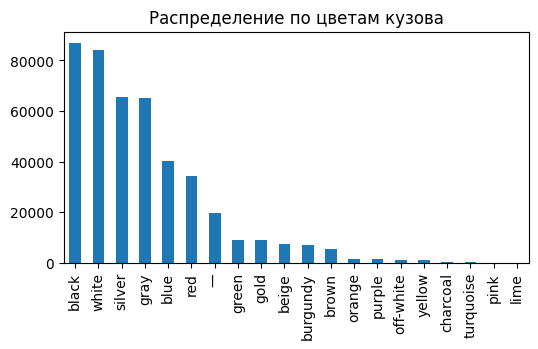

In [100]:
data['color'].value_counts().plot(kind='bar',figsize=(6,3),title='Распределение по цветам кузова'); plt.show()

In [101]:
for d in (data, data_test):                                  # переименовываем неизвестное значение "-"
    d.loc[d['color'] == "—",'color'] = 'unknown' 

Пропусков менее 1%, заполним 'unknown':

In [102]:
for d in (data, data_test):
    d['color'].fillna('unknown',inplace=True)

Дубликатов нет. Неизвестные значения "-" и пропуски переименовали в "unknown".

### interior

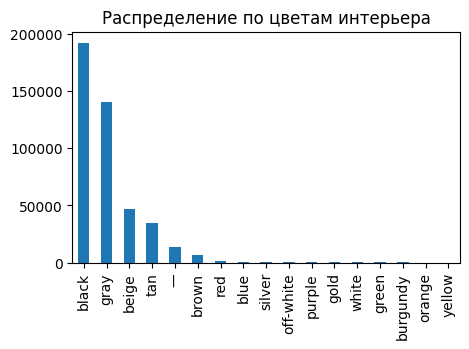

In [103]:
data['interior'].value_counts().plot(kind='bar',figsize=(5,3),title='Распределение по цветам интерьера'); plt.show()

In [104]:
for d in (data, data_test):                                     # переименовываем неизвестное значение "-"
    d.loc[d['interior'] == "—",'interior'] = 'unknown'

Пропусков менее 1%, заполним 'unknown':

In [105]:
for d in (data, data_test):
    d['interior'].fillna('unknown',inplace=True)

Дубликатов нет. Неизвестные значения "-" и пропуски переименовали в "unknown".

### seller

In [106]:
for d in (data, data_test):                                 # кол-во уникальных значений (обучающая / тестовая)
    print(d['seller'].nunique())

13017
7623


In [107]:
# доля от общей суммы продаж в обучающей выборке, которую делают 1500 продавцов
data.groupby('seller')['sellingprice'].sum().sort_values(ascending = False)[:1500].sum()/data['sellingprice'].sum()

0.907007874536313

Таким образом 91% выручки датасета осуществляет 12% продавцов (1500/13017).\
Переименуем остальные 88% продавцов в 'other':

In [108]:
# список продавцов, которые в сумме дают около 9% выручки обучающего датасета
seller_small = data.groupby('seller')['sellingprice'].sum().sort_values(ascending = False)[1500:].index

In [109]:
for d in (data, data_test):
    d.loc[d['seller'].isin(seller_small),'seller'] = 'other'

In [110]:
for d in (data, data_test):                            # кол-во уникальных значений после обработки (обучающая / тестовая)
    print(np.sort(d['seller'].unique()).shape[0])

1501
2558


In [111]:
# топ-100 продавцов; смотрим наличие неявных дубликатов
data.groupby('seller')['sellingprice'].sum().sort_values(ascending = False)[:100].index.sort_values()

Index(['aaero sweet company', 'adcock brothers inc',
       'ahfc/honda lease trust/hvt, inc.',
       'ahfc/honda lease trust/hvt, inc. eot',
       'ahfc/honda lease/trust/hvt, inc. eot acuras', 'alans autos', 'ari',
       'ars/avis budget group', 'ars/enterprise',
       'ars/ford-lincoln dealer program', 'automobiles paille inc',
       'avis budget group', 'avis corporation', 'avis rac/san leandro',
       'barco rent a truck', 'bmw mini financial services',
       'bmw na manheim new jersey', 'bmw north america',
       'bmw north america greer', 'capital one auto finance', 'carworks inc',
       'chrysler canada inc', 'chrysler capital', 'chrysler group,llc',
       'credit acceptance corp/vrs/southfield', 'donlen corporation',
       'dt credit corporation', 'dtg operations inc',
       'enterprise holdings/gdp', 'enterprise veh exchange/rental',
       'enterprise vehicle exchange / tra / rental / tulsa',
       'enterprise vehicle exchange/davenport',
       'enterprise vehi

In [112]:
# убираем неявные дубликаты
for d in (data,data_test):
    d.loc[d['seller']=='ahfc/honda lease trust/hvt, inc. eot','seller']        = 'ahfc/honda lease trust/hvt, inc.'
    d.loc[d['seller']=='ahfc/honda lease/trust/hvt, inc. eot acuras','seller'] = 'ahfc/honda lease trust/hvt, inc.'
    d.loc[d['seller']=='ford motor credit company,llc','seller']               = 'ford motor credit company'
    d.loc[d['seller']=='ford motor credit company,llc pd','seller']            = 'ford motor credit company'
    d.loc[d['seller']=='gm financial leasing','seller']                        = 'gm financial'
    d.loc[d['seller']=='nissan infiniti lt','seller']                          = 'nissan-infiniti lt'   

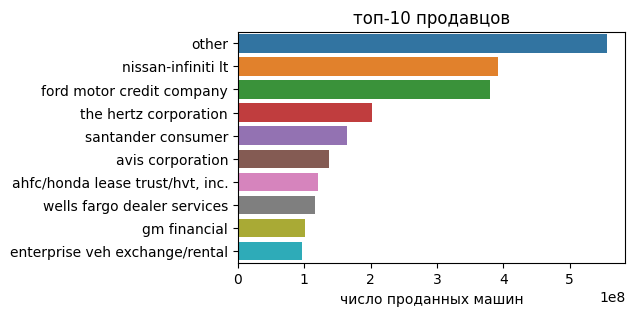

In [113]:
plt.figure(figsize=(5,3))
sns.barplot(x=data.groupby('seller')['sellingprice'].sum().sort_values(ascending = False)[:10],
            y=data['seller'].value_counts()[:10].index).set(title='топ-10 продавцов')
plt.xlabel('число проданных машин'); plt.show()

### vin

In [114]:
for d in (data,data_test):            # кол-во дубликатов   (обучающая  /  тестовая)
    print(d['vin'].duplicated().sum())

0
0


### transmission

В признаке 12% пропусков. В модуле vininfo значений transmission, отсутствующих в исходных данных задачи, нет. <br> Заполним пропуски 'unknown':

In [115]:
for d in (data,data_test):
    d['transmission'].fillna('unknown',inplace=True)

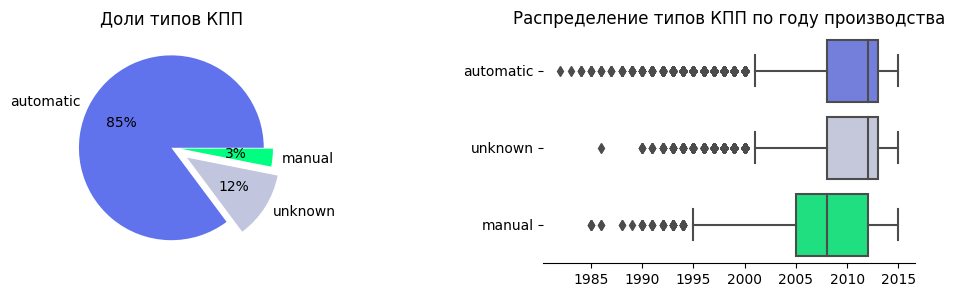

In [116]:
f, (ax_1, ax_2) = plt.subplots(1,2,figsize=(12,3),gridspec_kw={"wspace": 0.5})
data['transmission'].value_counts().plot(kind='pie',autopct='%1.0f%%',label='', explode = (0,0.2,0.1),
                                         colors = ['#6172ed','#c1c5de','#00FF80'], ax=ax_1)
sns.boxplot(data=data,x='year',y='transmission',palette=('#6172ed','#c1c5de','#00FF80'), ax=ax_2)
ax_1.set_title('Доли типов КПП'); ax_2.set_title('Распределение типов КПП по году производства')
sns.despine(ax=ax_2,left=True);  plt.ylabel(None); plt.xlabel(None); plt.show()

В data_test практически аналогичное распределение.

По диаграмме размаха видим, неизвестные значения практически полностью совпадают с характеристикой автоматической КПП.\
Тем не менее 'unknown' также входит в диапазон 'manual'.\
Заполним пропуски с помощью ML.

#### ML gap-filling

In [117]:
# делим data на 2 df - c пропусками и без; также убираем незначимые признаки
data_no_gap = data.query("transmission != 'unknown'").drop(['vin','color','interior','saledate','saledate_dt','saledate_unix',
                                                            'month','weekday','mileage_per_year'],axis=1)  # df без пропусков
data_gap    = data.query("transmission == 'unknown'").drop(['vin','color','interior','saledate','saledate_dt','saledate_unix',
                                                            'month','weekday','mileage_per_year'],axis=1)  # df c пропусками

In [118]:
# кодируем категориальные признаки 

encoder_t = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1) # создаём структуру данных

col_obj = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'seller', 'country']            # категориальные признаки
col_num = ['year', 'condition', 'odometer', 'lifetime']                         # количественные признаки (без 'sellingprice')

encoder_t.fit(data_no_gap[col_obj])                                             # получаем список категориальных признаков

data_no_gap_ordinal = pd.DataFrame(encoder_t.transform(data_no_gap[col_obj]), data_no_gap.index, col_obj).\
                      join(data_no_gap[col_num])
data_gap_ordinal    = pd.DataFrame(encoder_t.transform(data_gap[col_obj]), data_gap.index, col_obj).\
                      join(data_gap[col_num])

In [119]:
# формируем признаки и целевой признак
features_no_gap = data_no_gap_ordinal.drop('transmission',axis=1)
target_no_gap   = data_no_gap_ordinal['transmission']

featires_gap    = data_gap_ordinal.drop('transmission',axis=1)

In [120]:
# разбиваем датасеты на обучающие и валидационные
features_no_gap_train, features_no_gap_valid, target_no_gap_train, target_no_gap_valid = \
    train_test_split(features_no_gap, target_no_gap, test_size=0.25, random_state=12345, stratify=target_no_gap)

In [121]:
# обучаем модель Случайного леса
model = RandomForestClassifier(random_state=12345)
model.fit(features_no_gap_train, target_no_gap_train)

RandomForestClassifier(random_state=12345)

In [122]:
print(f'accuracy = {model.score(features_no_gap_valid, target_no_gap_valid):.3f}, \
      f1 = {f1_score(target_no_gap_valid,model.predict(features_no_gap_valid)):.3f}')

accuracy = 0.968,       f1 = 0.308


In [123]:
# проверка на вменяемость с константной моделью (предсказываем самый популярный ответ)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_no_gap_train, target_no_gap_train)
print(f'accuracy = {dummy_clf.score(features_no_gap_valid, target_no_gap_valid):.3f}, \
      f1 = {f1_score(target_no_gap_valid,dummy_clf.predict(features_no_gap_valid)):.3f}')

accuracy = 0.965,       f1 = 0.000


In [124]:
# предсказваем тип КПП и вписываем его в закодированный df
data_gap_ordinal['transmission'] = pd.Series(model.predict(featires_gap),featires_gap.index)

In [125]:
# раскодируем предсказанный тип КПП и вписываем его в исходный df в места пропусков
data.loc[data['transmission'] == 'unknown','transmission'] = \
    pd.DataFrame(encoder_t.inverse_transform(data_gap_ordinal[col_obj]), data_gap.index, col_obj)['transmission']

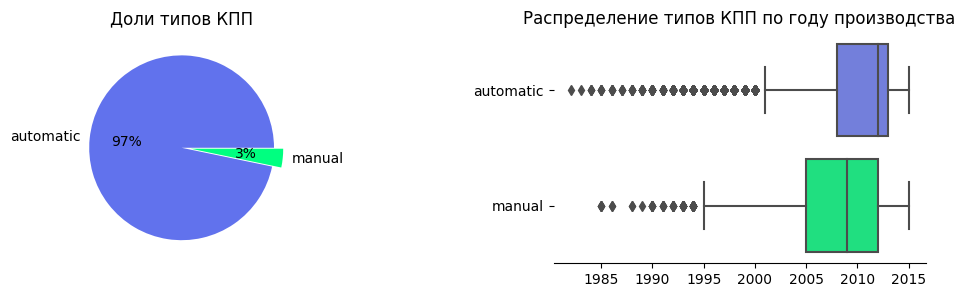

In [126]:
f, (ax_1, ax_2) = plt.subplots(1,2,figsize=(12,3),gridspec_kw={"wspace": 0.5})
data['transmission'].value_counts().plot(kind='pie',autopct='%1.0f%%',label='', explode = (0,0.1),
                                         colors = ['#6172ed','#00FF80'], ax=ax_1)
sns.boxplot(data=data,x='year',y='transmission',palette=('#6172ed','#00FF80'), ax=ax_2)
ax_1.set_title('Доли типов КПП'); ax_2.set_title('Распределение типов КПП по году производства')
sns.despine(ax=ax_2,left=True);  plt.ylabel(None); plt.xlabel(None); plt.show()

Практически все пропуски были отнесены к автоматической КПП, как и предполагалось выше при анализе диаграммы размаха.

🥝 **data_test** 🥝

Используем кодировщик и модель, полученные на обучающей выборке.

In [127]:
# формируем из data_test выборку с пропусками в трансмиссии; также убираем незначимые признаки
data_t_gap    = data_test.query("transmission == 'unknown'").drop(['vin','color','interior','saledate','saledate_dt',
                                                                   'saledate_unix','month','weekday','mileage_per_year'],axis=1)

In [128]:
# кодируем категориальные признаки 
data_t_gap_ordinal    = pd.DataFrame(encoder_t.transform(data_t_gap[col_obj]), data_t_gap.index, col_obj).\
                        join(data_t_gap[col_num])

In [129]:
# формируем признаки (без целевого)
featires_gap    = data_t_gap_ordinal.drop('transmission',axis=1)

In [130]:
# предсказваем тип КПП и вписываем его в закодированный df
data_t_gap_ordinal['transmission'] = pd.Series(model.predict(featires_gap),featires_gap.index)

In [131]:
# раскодируем предсказанный тип КПП и вписываем его в исходный df в места пропусков
data_test.loc[data_test['transmission'] == 'unknown','transmission'] = \
    pd.DataFrame(encoder_t.inverse_transform(data_t_gap_ordinal[col_obj]), data_t_gap.index, col_obj)['transmission']

In [132]:
data_test['transmission'].value_counts(normalize=True) # доли автоматической КПП и ручной после заполнения пропусков

automatic    0.966936
manual       0.033064
Name: transmission, dtype: float64

Практически все пропуски в тестовом датасете были отнесены к автоматической КПП.

### Изменение типа данных

Для уменьшения занимаемого объёма памяти изменим тип данных в ряде количественных признаков.

In [133]:
for d in (data,data_test):
    d['condition'] = (d['condition']*10).astype('int8')                                   # condition *10 чтобы перевести в int
    d[['month','lifetime','weekday']] = d[['month','lifetime','weekday']].astype('int8')
    d['year'] = d['year'].astype('int16')
    d[['odometer','mileage_per_year']] = d[['odometer','mileage_per_year']].astype('int32')
    
data['sellingprice'] = data['sellingprice'].astype('int32')                               # вне цикла, т.к. в data_test нет

## Взаимосвязь признаков

### Ordinal Encoding

Для нахождения корреляции между всеми признаками закодирум категориальные:

In [134]:
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1) # создаём структуру данных
col_obj = [c for c in data if data[c].dtype == object]                           # определяем категориальные признаки
col_num = [c for c in data if data[c].dtype != object]                           # определяем количественные признаки
encoder_oe.fit(data[col_obj])                                                    # получаем список категориальных признаков
data_oe = pd.DataFrame(encoder_oe.transform(data[col_obj]), data.index, col_obj).join(data[col_num])

In [135]:
# кодируем тестовый df; в количественных колонках нет sellingprice, поэтому от обучающего df col_num не используем
data_t_oe = pd.DataFrame(encoder_oe.transform(data_test[col_obj]), data_test.index, col_obj).join(
            data_test[[c for c in data_test if data[c].dtype != object]])

### "тепловая" таблица

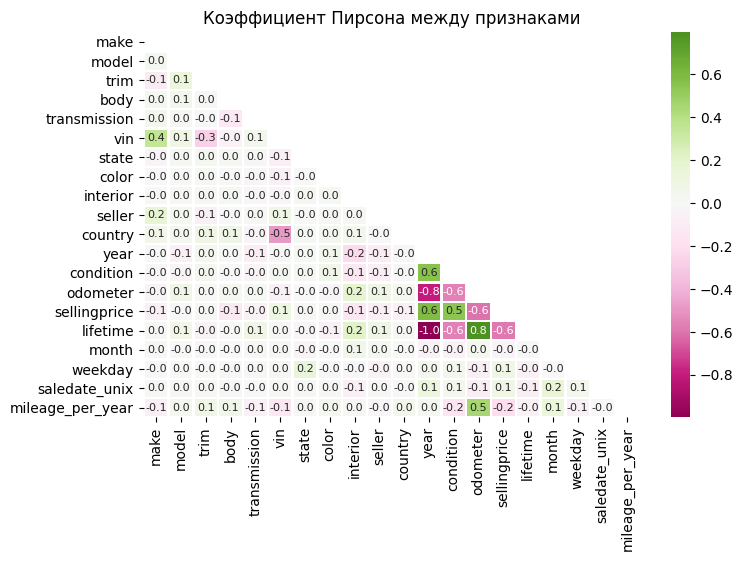

In [136]:
plt.figure(figsize=(8,5))
sns.heatmap(data_oe.drop('saledate',axis=1).corr(),annot=True,cmap='PiYG',
            linewidth=1,fmt='.1f',center= 0,annot_kws={"size":8}, 
            mask = np.triu(data_oe.drop('saledate',axis=1).corr()))
plt.title('Коэффициент Пирсона между признаками');  plt.show()

### Диаграммы рассеяния

На ряде диаграмм наблюдаем некие закономерности - сгустки, пропуски, формирование линий.  Где-то более, где-то менее проявляющиеся.

In [137]:
col_1_7   = ['make',        'model',      'trim',    'body',   'transmission','vin',          'state'           ]
col_8_14  = ['color',       'interior',   'seller',  'country','year',        'condition',    'odometer'        ]
col_15_21 = ['sellingprice','saledate_dt','lifetime','month',  'weekday',     'saledate_unix','mileage_per_year']

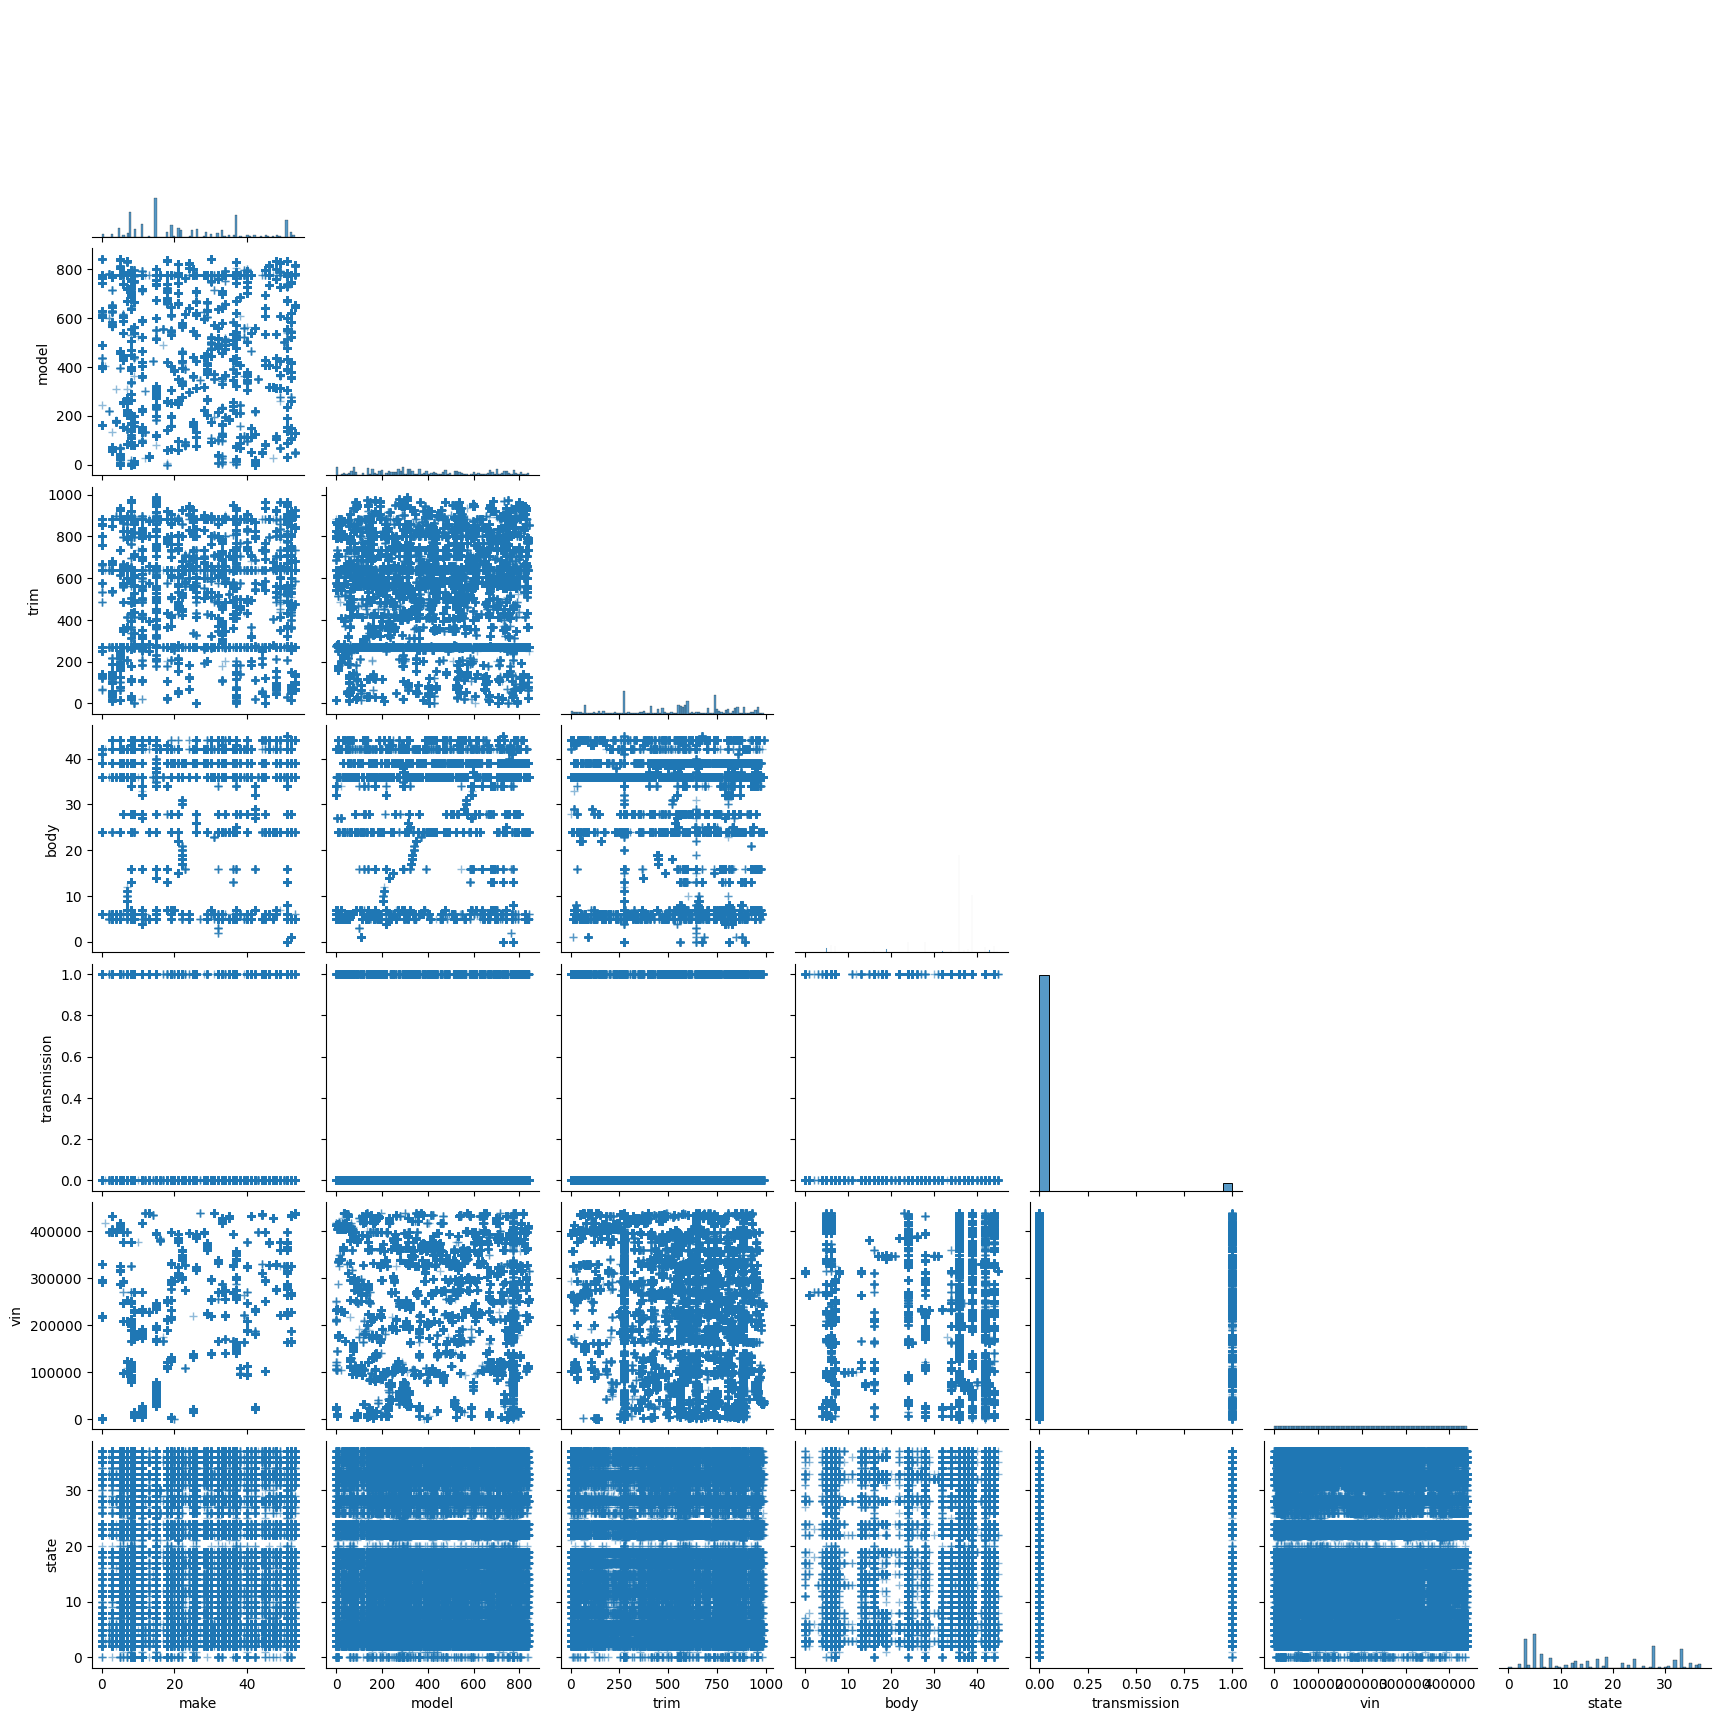

In [138]:
sns.pairplot(data_oe, vars=col_1_7, corner=True, plot_kws=dict(alpha=0.5, marker="+", linewidth=1));  plt.show()

👆  model / make / trim / body - логично, т.к. определённые модели делает определённый производитель.

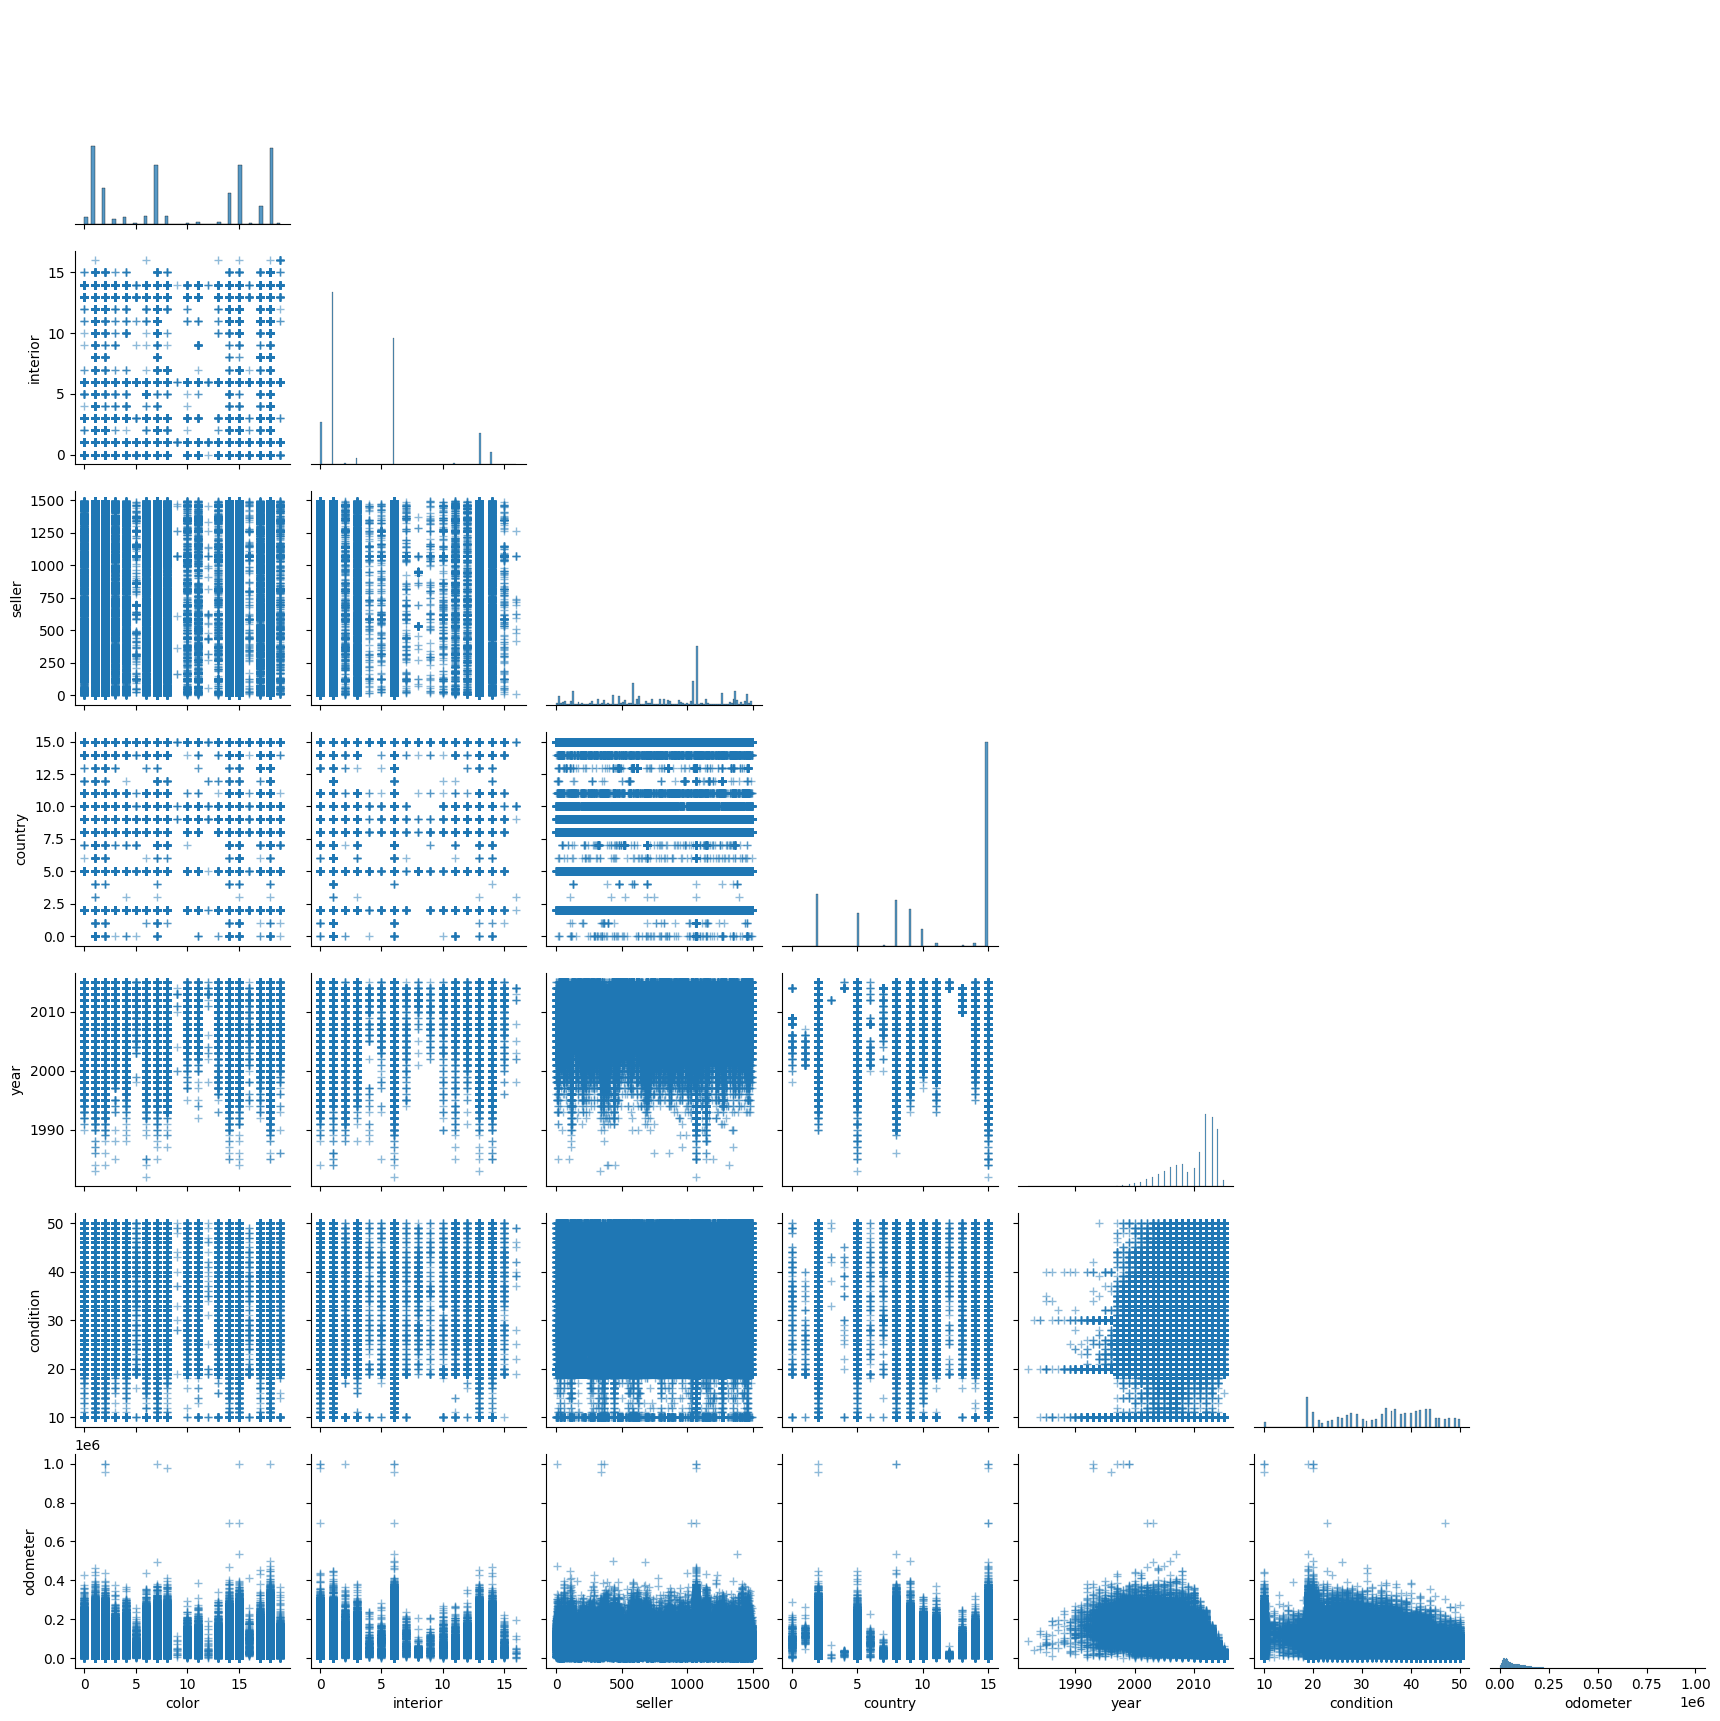

In [139]:
sns.pairplot(data_oe, vars=col_8_14, corner=True, plot_kws=dict(alpha=0.5, marker="+", linewidth=1));  plt.show()

👆 Все признаки коррелируют между собой. Особенно видна связь year / odometer.

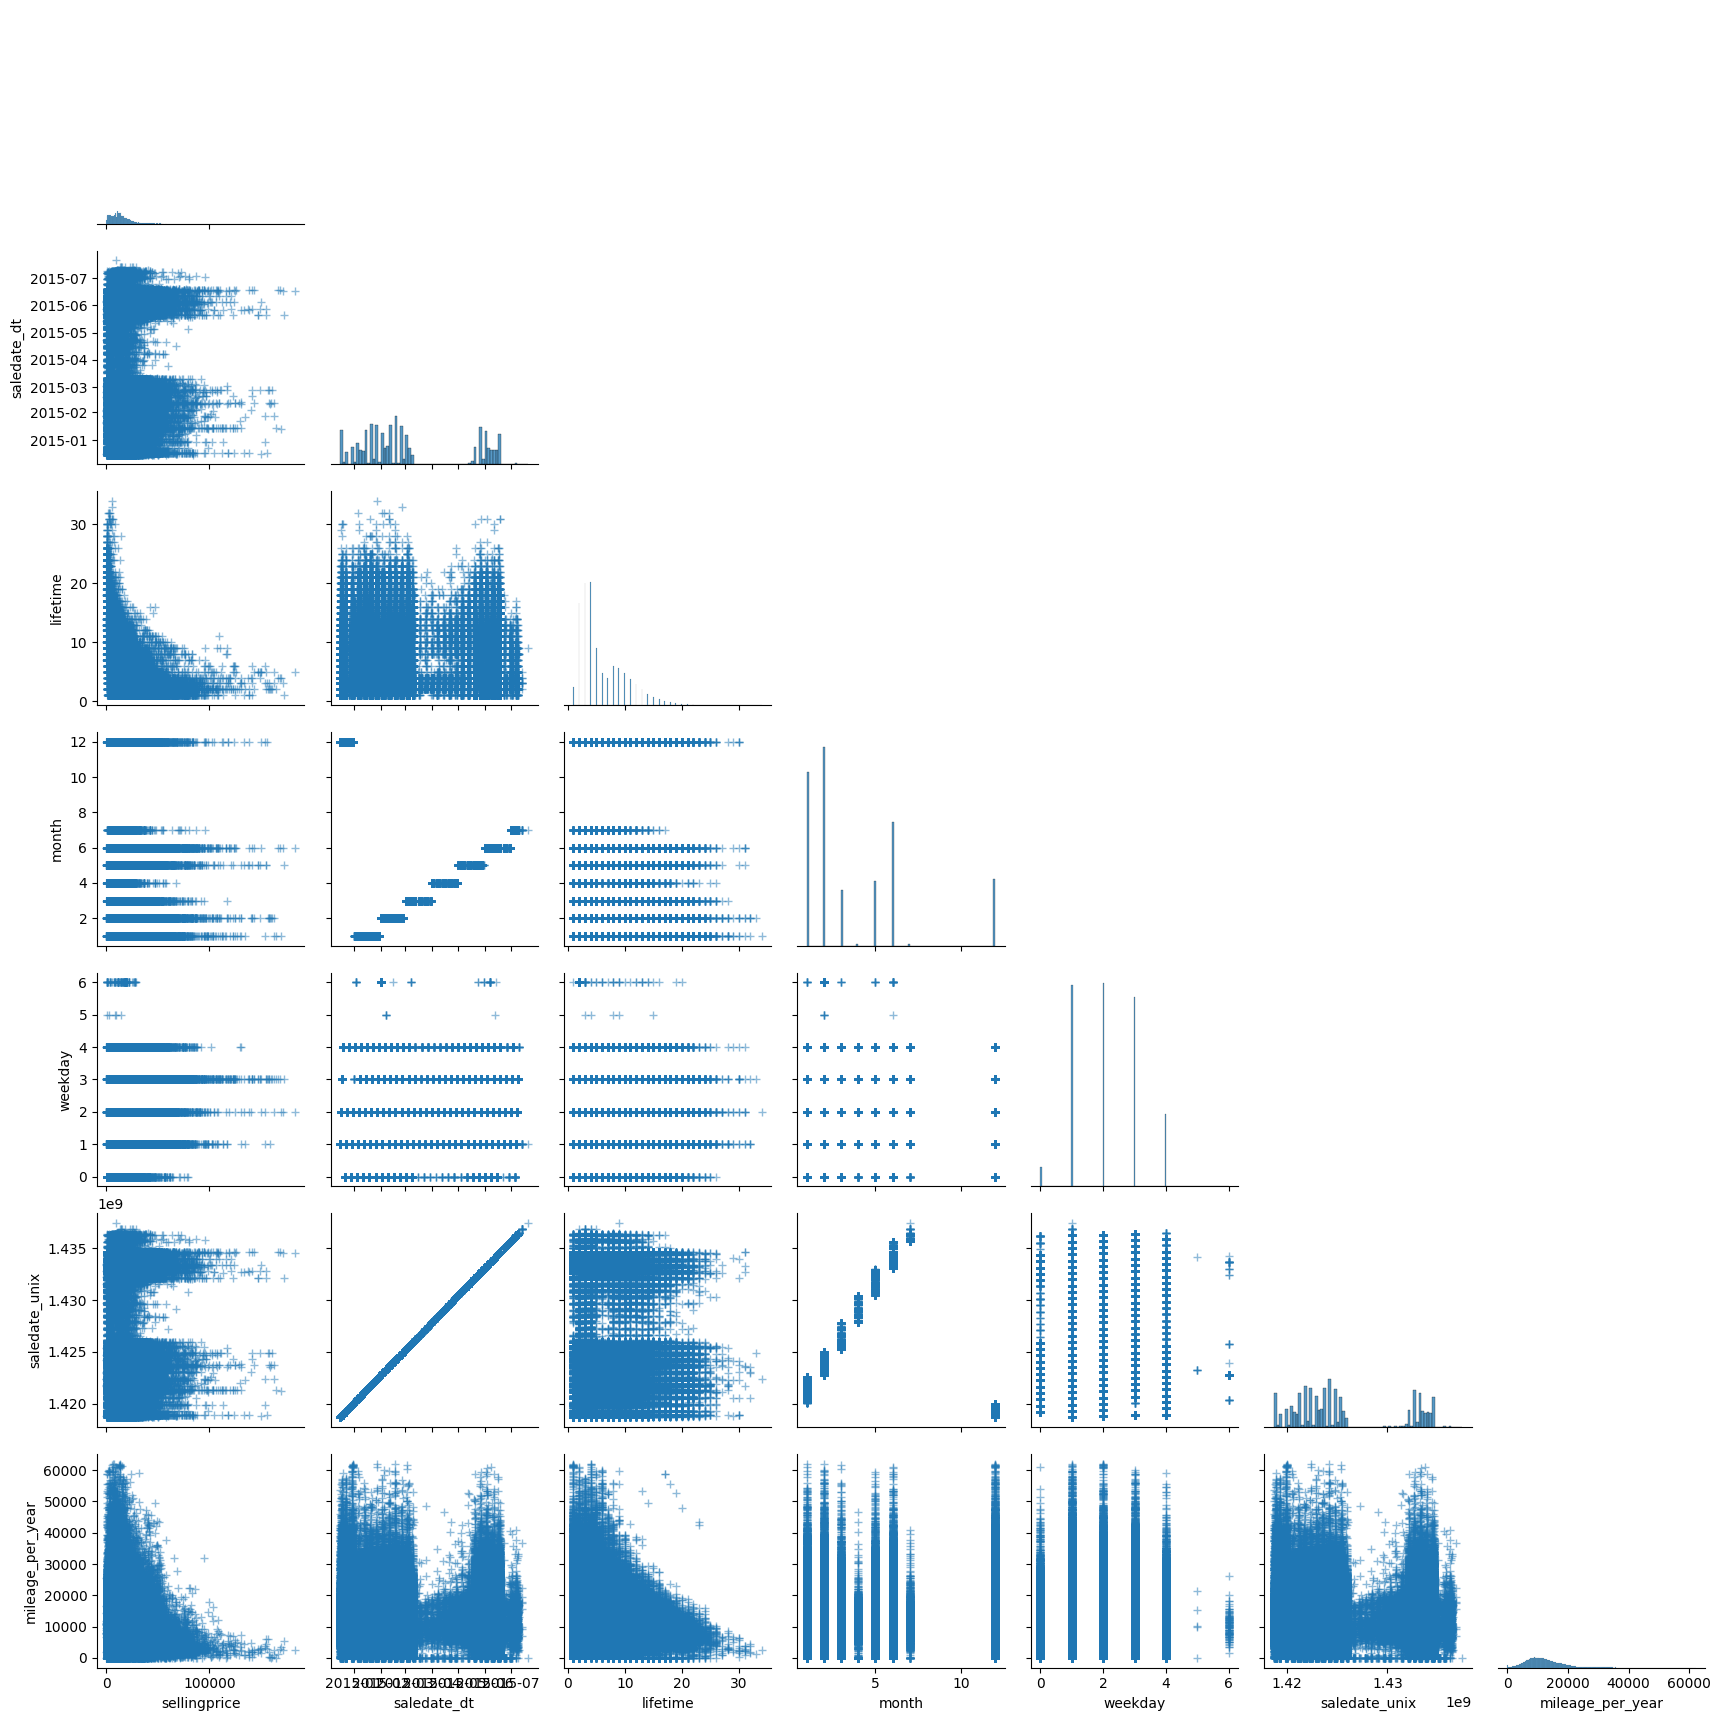

In [140]:
sns.pairplot(data_oe, vars=col_15_21, corner=True, plot_kws=dict(alpha=0.5, marker="+", linewidth=1));  plt.show()

👆 sellingprice коррелирует во всех пересечениях; особенно в mileage_per_year и lifetime

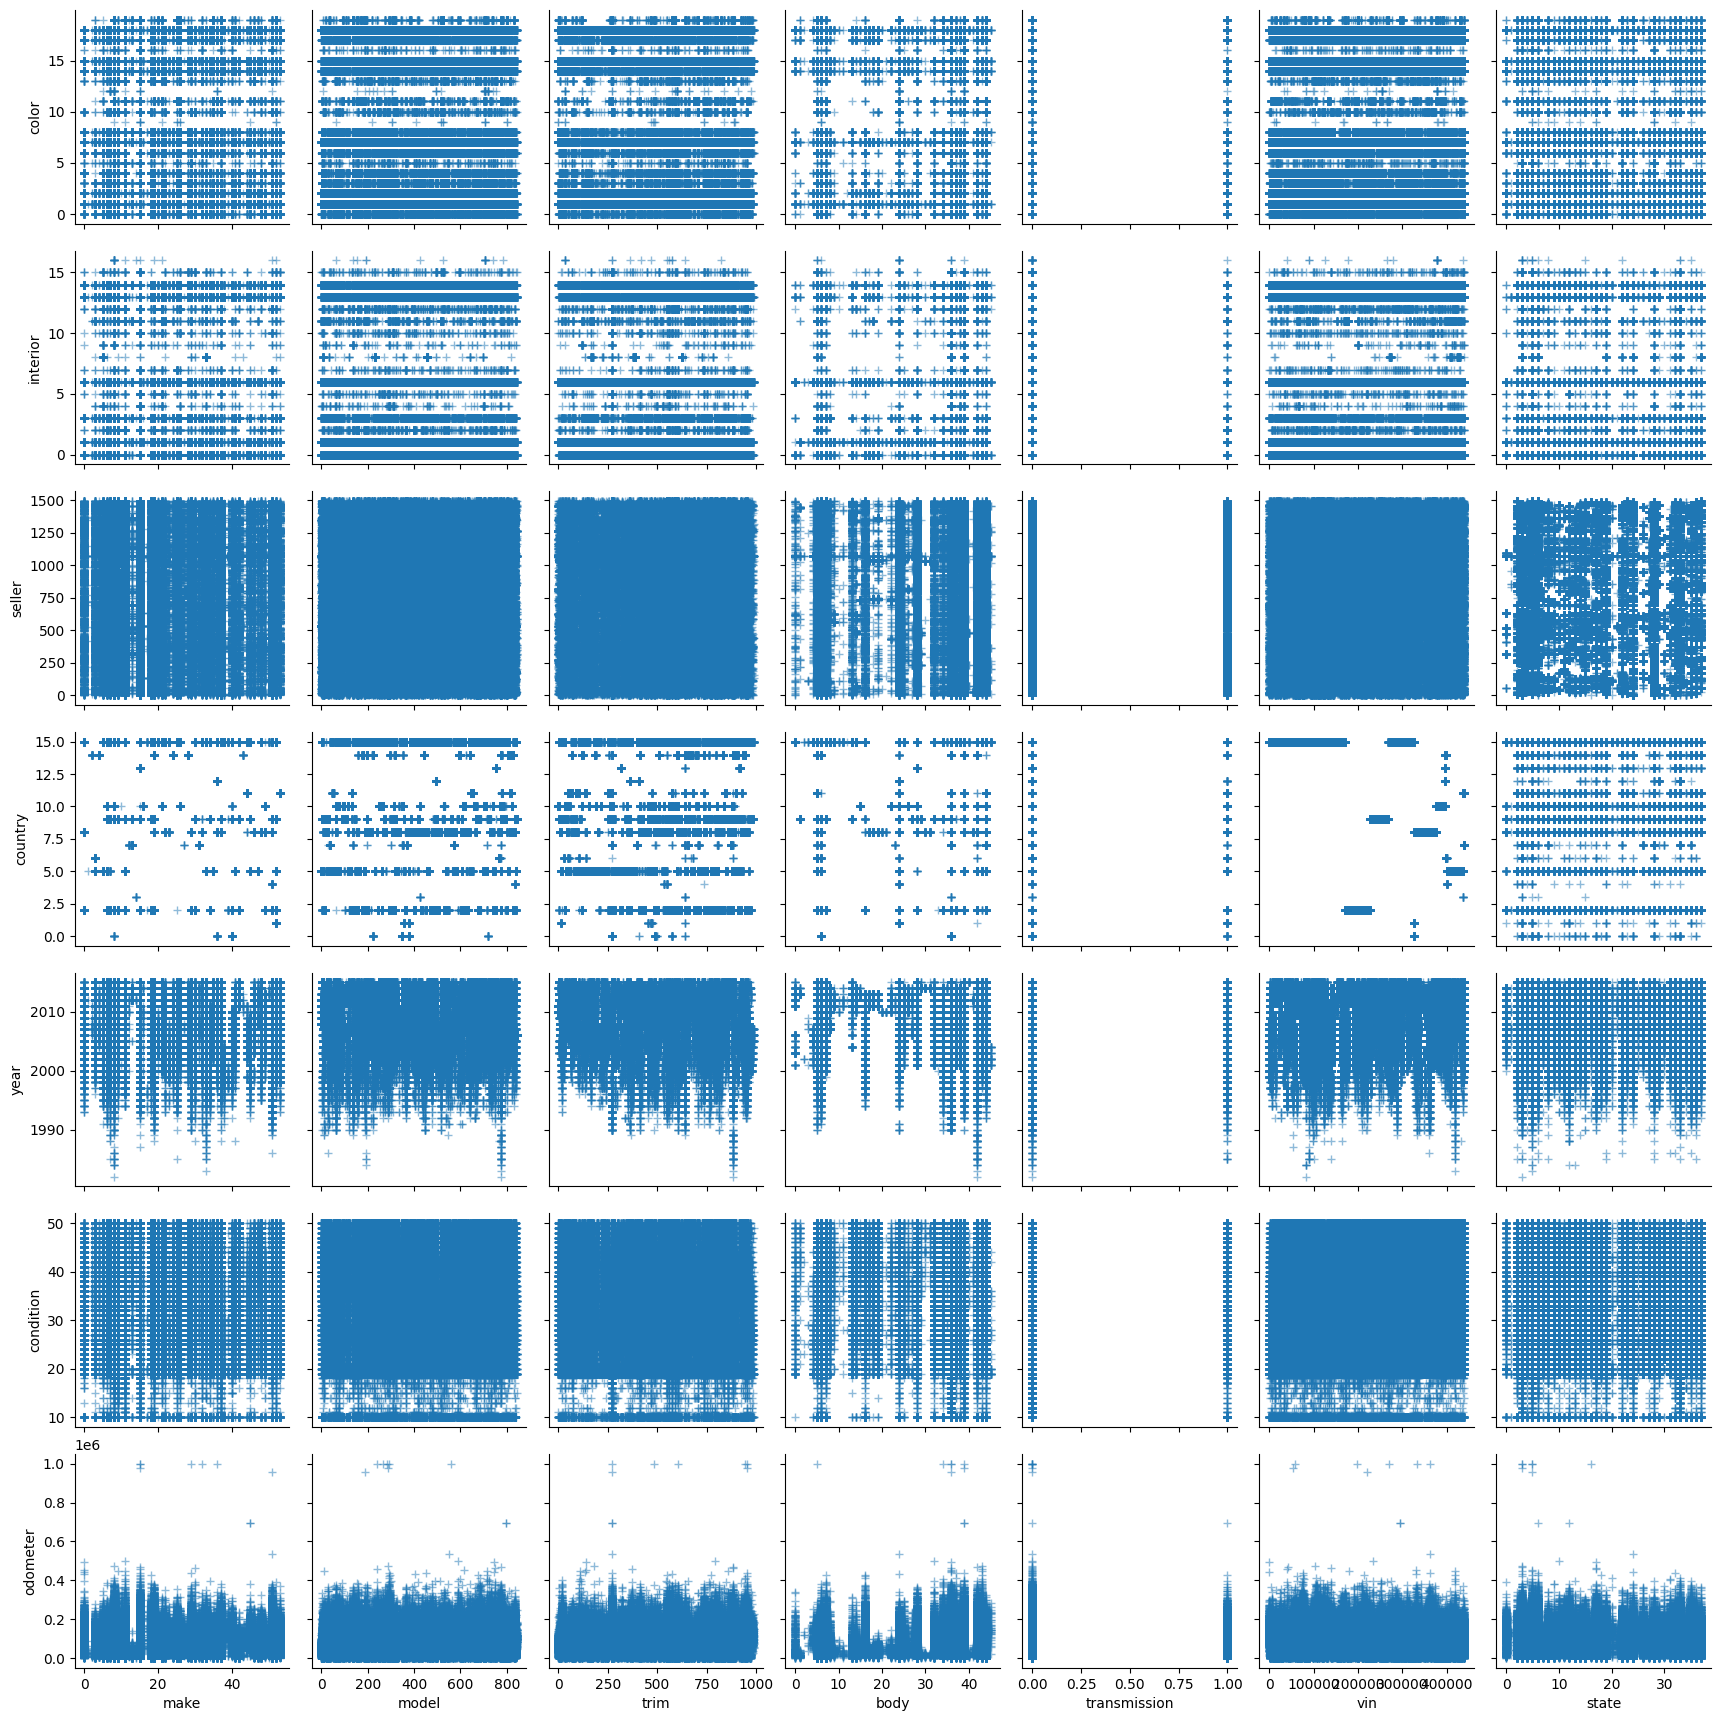

In [141]:
sns.pairplot(data_oe, x_vars=col_1_7,y_vars=col_8_14, plot_kws=dict(alpha=0.5, marker="+",linewidth=1)); plt.show()

👆 никак не коррелируют seller / model,  seller / trim, seller / vin 

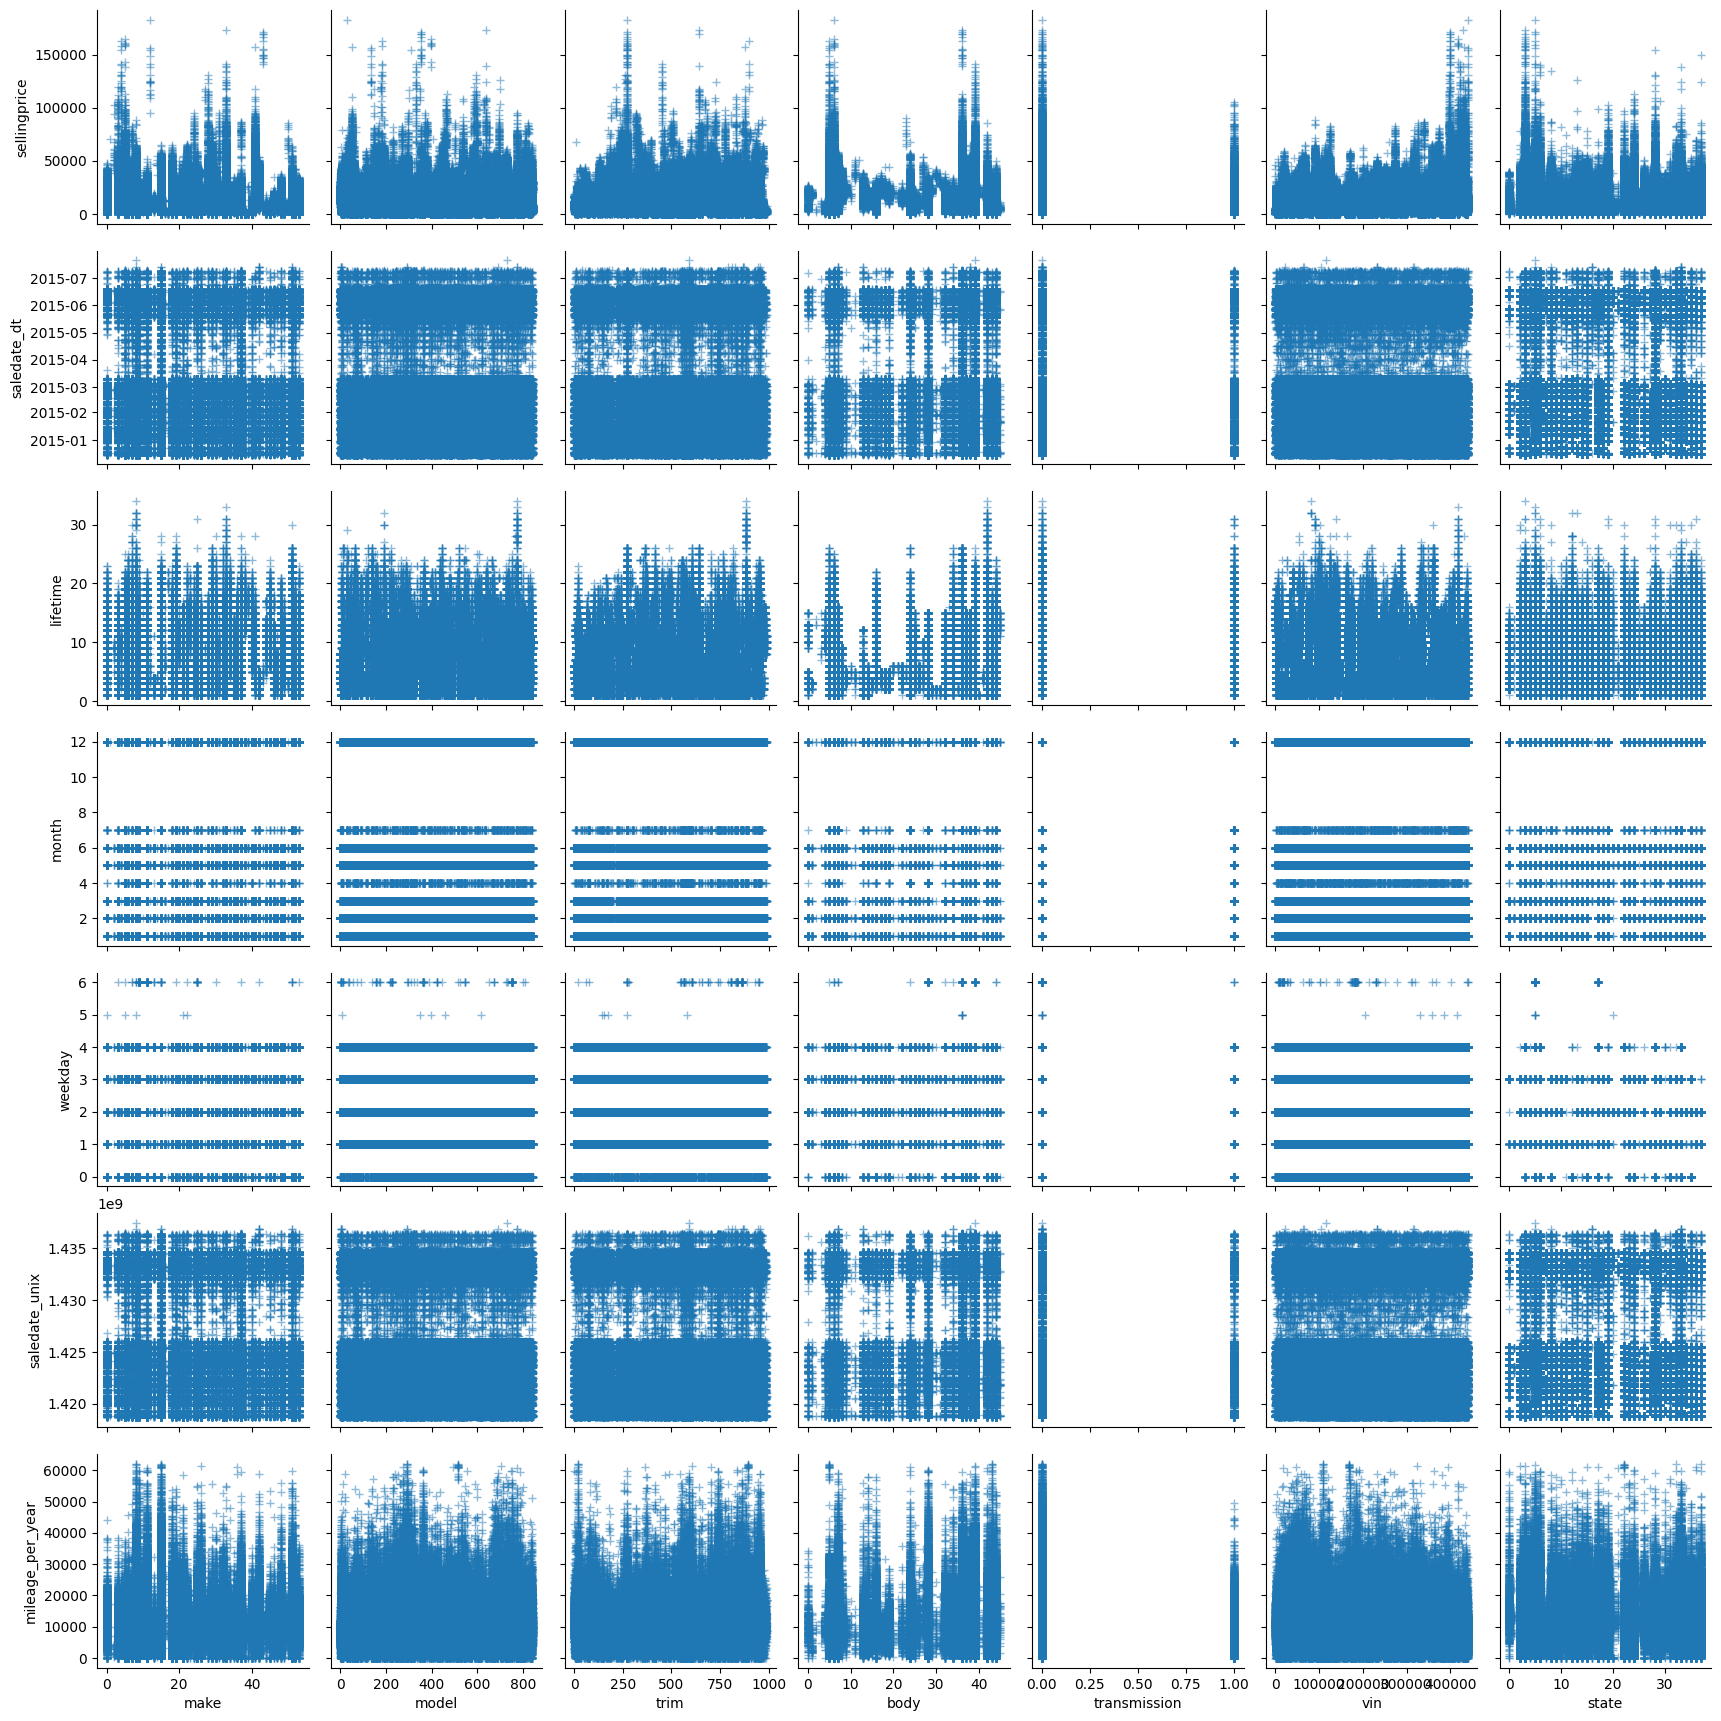

In [142]:
sns.pairplot(data_oe, x_vars=col_1_7,y_vars=col_15_21, plot_kws=dict(alpha=0.5, marker="+",linewidth=1)); plt.show()

👆 sellingprice коррелирует во всех пересечениях

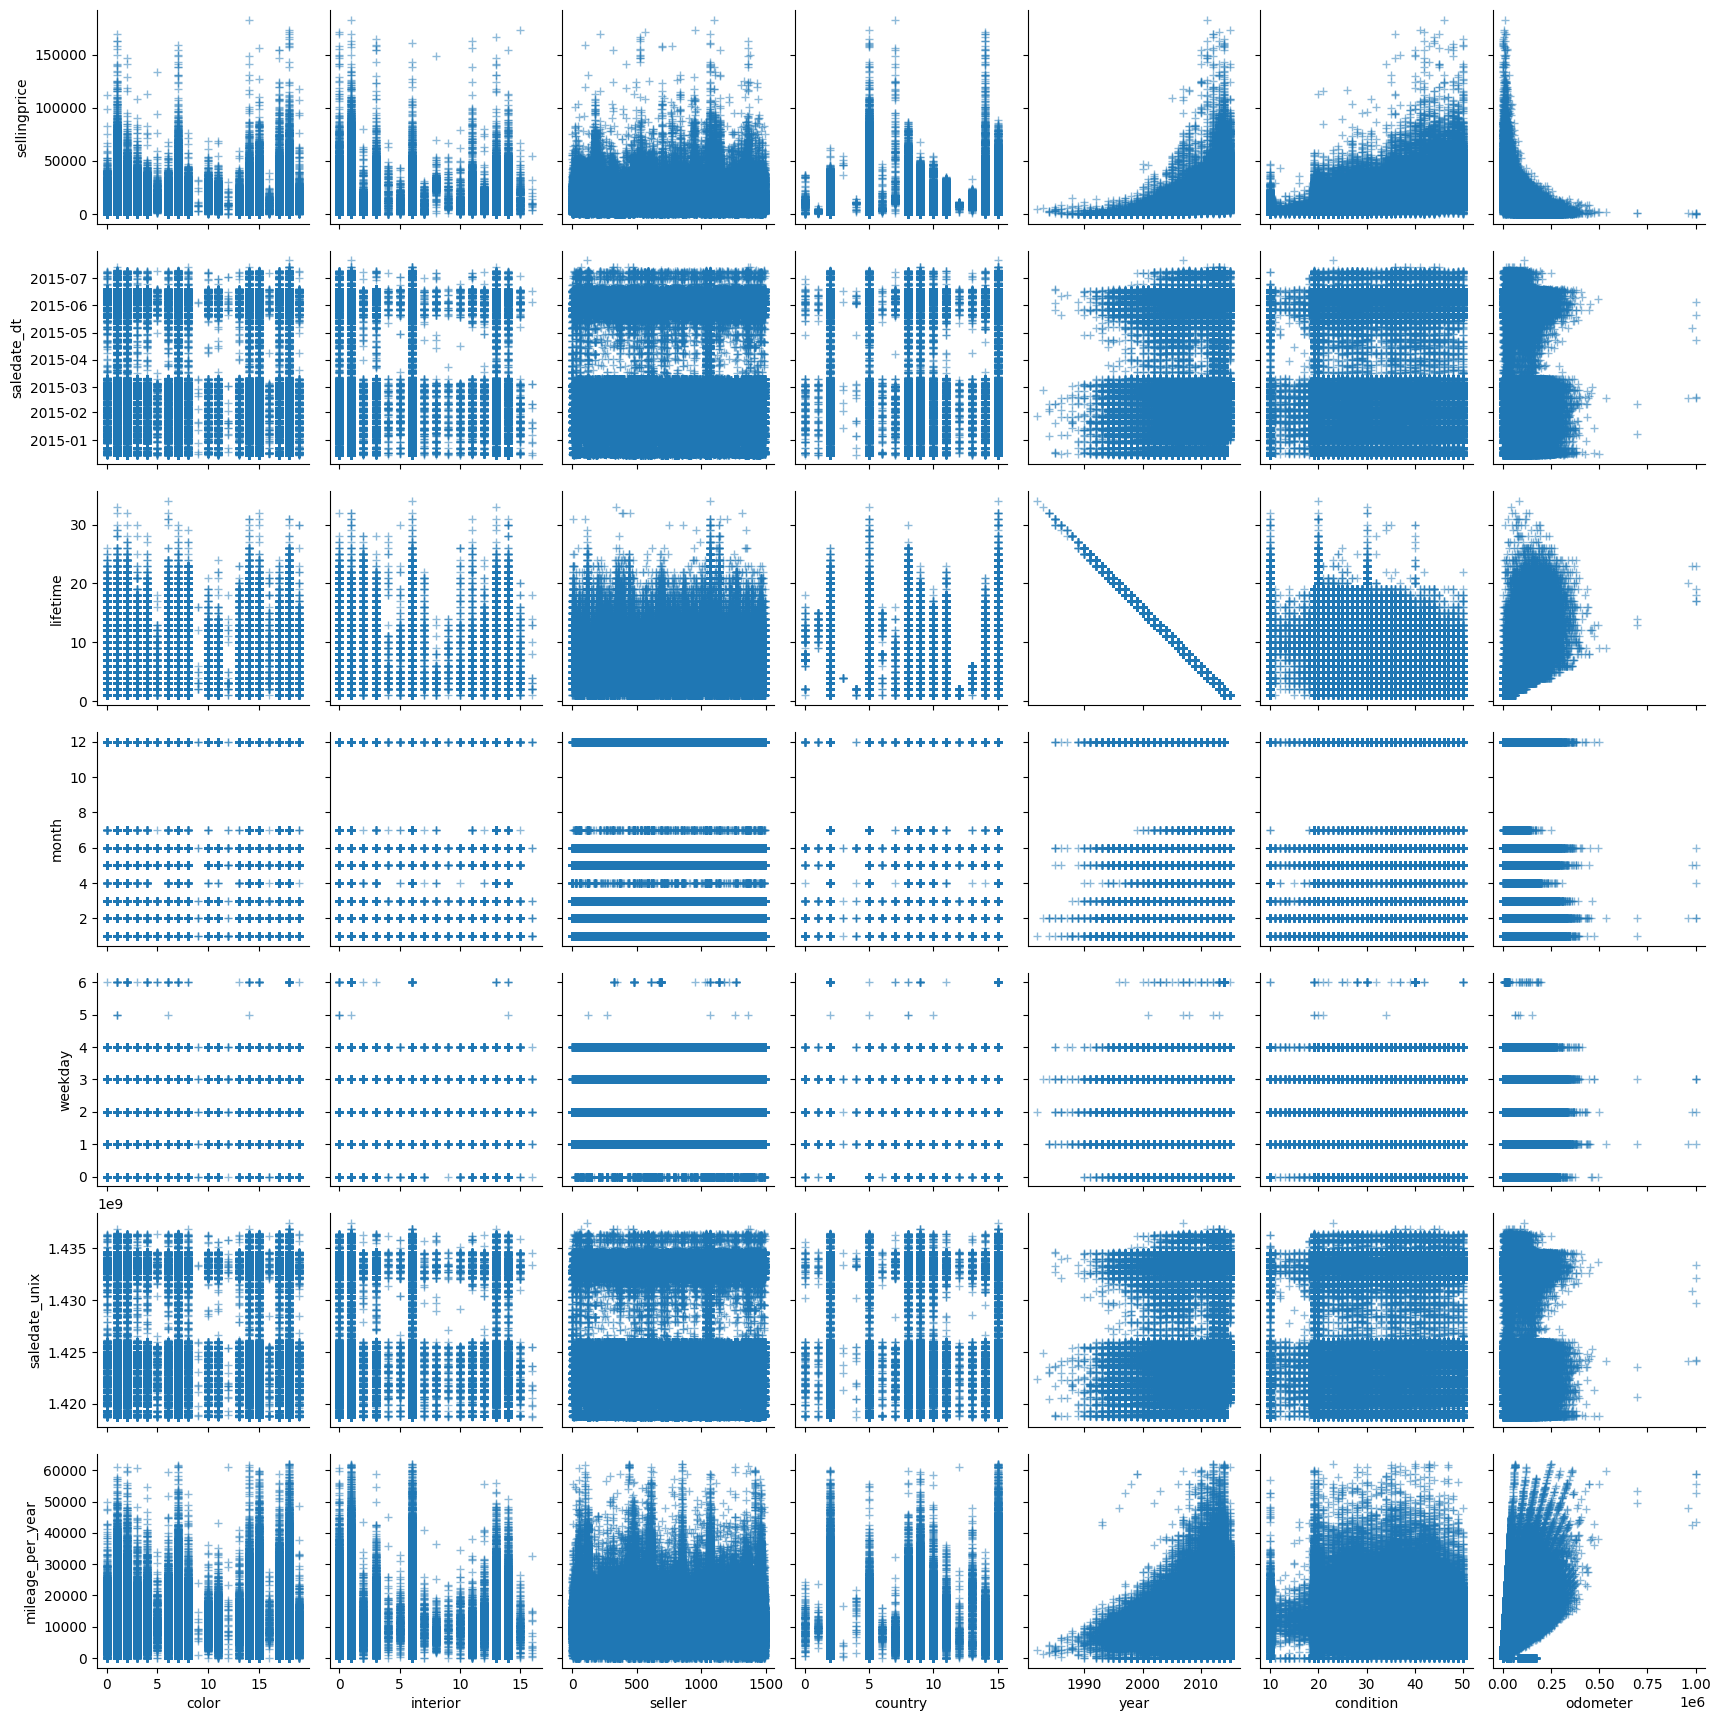

In [143]:
sns.pairplot(data_oe, x_vars=col_8_14,y_vars=col_15_21, plot_kws=dict(alpha=0.5,marker="+",linewidth=1)); plt.show()

👆 sellingprice коррелирует во всех пересечениях; особенно явно в year, condition, odometer

<a id= 'preprocessing'></a>
### Вывод по предобработке и анализу

In [144]:
for d in (data, data_test):         # число пропусков во всём датасете после обработки (обучающий / тестовый)
    print (d.isna().sum().sum())

0
0


In [145]:
# доля удалённых объектов (обучающий / тестовый)
print(round((440236 - data.shape[0])/440236, 5)) 
print(round((110060 - data_test.shape[0])/110060, 5)) 

0.00081
0.0


Обработка:

* 3 датасета: обучающий (440236 х 15), тестовый (110060 х 14), образцовый (пример предсказания; 110060 х 2);
* пропуски: обучающий (97072, 22%), тестовый (24593, 22%); после обработки: пропусков нет, удалено 356 объектов (0.08%) в обучающей выборке и 0 в тестовой;
* распределение в обучающей и тестовой выборках практически полностью идентичное;
* явных полных дубликатов объектов нет;
* созданы новые признаки: 'saledate_dt', 'lifetime', 'month', 'weekday', 'saledate_unix', 'mileage_per_year', 'country';
* продажи в датасетах за первое полугодие 2015г.; машины, изготовлены в диапазоне от 1982 до 2015г.; срок эксплуатации до 34 лет;
* чаще всего автомобили продаются со вторника по четверг;
* в 'make' сократили число уникальных значений ~ в 2 раза, в 'model' на 12%, в 'trim' в 2 раза, в 'body' в 2 раза;
* более 50% машин изготовлены в США; далее в рейтинге объёмов производства идут Канада, Япония, Мексика, Германия, Южная Корея;
* топ цветов: чёрный, белый, серебристый, серый, голубой;
* сократили кол-во уникальных значений продавцов в обучающей и тестовой выборках соответсвенно в 9 и в 3 раза; переименовали 88% продавцов в 'other'; это небольшие продавцы, которые делают 9% выручки; 12% продавцов делает 91% выручки, их оставили с уникальными именами;
* доля автомобилей с АКПП - 97%, остальные с ручной КПП; были пропуски, которые заполнили с помощью МЛ;
* в ряде количественных признаков изменили тип данных с int64 на менее памятизатратные (int8,16,32) - позволило далее применить OHE;

Взаимосвязь (жирным выделены предполагаемые признаки для ML):
* мультиколлинеарность между: **year** и lifetime;
* высокая корреляция между: year и odometer; odometer и lifetime;
* средняя корреляция между: **sellingprice** и **year**, **condition**, **odometer**, lifetime; odometer и mileage_per_year;
* слабая корреляция между: vin и country,make,**trim**;
* очень слабая корреляция между: **sellingprice** и **make**, **body**, vin, **interrior**, **seller**, **country**, **mileage_per_year**, **saledate_unix**, **weekday**.

На диаграммах рассеяния видим, что практически все признаки связаны между собой - где-то в меньшей, где-то в большей степени.

## Machine Learning

### (OE) отбор признаков, разбиение, масштабирование

In [146]:
# делим df на признаки и целевой признак; отбираем только значимые признаки
features = data_oe[['make','model','trim','body','transmission','state','color','interior','seller','country','year',
                    'condition','odometer','weekday','saledate_unix']]
target   = data_oe['sellingprice']

features_t = data_t_oe[['make','model','trim','body','transmission','state','color','interior','seller','country','year',
                        'condition','odometer','weekday','saledate_unix']]

In [147]:
# разбиваем датасеты на обучающие и валидационные (features_train/valid, target_train/valid)
ft, fv, tt, tv = train_test_split(features, target, test_size=0.25, random_state=12345)

In [148]:
# масштабируем признаки
scaler = StandardScaler()
scaler.fit(ft)
ft_scaled = scaler.transform(ft)
fv_scaled = scaler.transform(fv)

🥝 **вариант с меньшим числом признаков** 🥝

Отобрали на основе feature_impotance ([ниже](#feature_importance)).

In [151]:
# делим df на признаки и целевой признак; отбираем только значимые признаки
features2   = data_oe  [['make','model','body','country','year','condition','odometer','trim','month']]
features_t2 = data_t_oe[['make','model','body','country','year','condition','odometer','trim','month']]

In [152]:
# разбиваем датасеты на обучающие и валидационные (features_train/valid, target_train/valid)
ft2, fv2, tt2, tv2 = train_test_split(features2, target, test_size=0.25, random_state=12345)

In [153]:
# масштабируем признаки
scaler2 = StandardScaler()
scaler2.fit(ft2)
ft_scaled2 = scaler2.transform(ft2)
fv_scaled2 = scaler2.transform(fv2)

### One Hot Encoding

Признаки для OHE отобраны наиболее влиятельные (feature_importance), который определены [далее](#feature_importance) на основании работы модели с OE:\
'make','model','body','country','trim', 'year', 'condition', 'odometer', 'month'

In [162]:
# разбиваем датасеты на обучающие и валидационные (features_train/valid, target_train/valid)
ft, fv, tt, tv = train_test_split(data.drop('sellingprice', axis=1), data['sellingprice'], 
                                  test_size=0.25, random_state=12345)

In [163]:
col_obj_ohe = ['make','model','body','country','trim']
col_num_ohe = ['year','condition','odometer','month']
encoder_ohe = OneHotEncoder(handle_unknown = 'ignore')
encoder_ohe.fit(ft[col_obj_ohe])

ft_ohe = pd.DataFrame(encoder_ohe.transform(ft[col_obj_ohe]).astype('int8').toarray(),
                      columns=encoder_ohe.get_feature_names_out(),
                      index=ft.index).join(ft[col_num_ohe])

In [164]:
#кодируем валидационный df
fv_ohe = pd.DataFrame(encoder_ohe.transform(fv[col_obj_ohe]).astype('int8').toarray(),
                      columns=encoder_ohe.get_feature_names_out(),
                      index=fv.index).join(fv[col_num_ohe])

In [165]:
#кодируем тестовый df
f_test_ohe = pd.DataFrame(encoder_ohe.transform(data_test[col_obj_ohe]).astype('int8').toarray(),
                          columns=encoder_ohe.get_feature_names_out(),
                          index=data_test.index).join(data_test[col_num_ohe])

Масштабировать не будем, т.к. планируем использовать только "деревянные" модели.

### ML функция

In [168]:
def ml(algorithm, ft, tt, fv, tv, depth=None, est=100, criterion='squared_error',min_samples_split=2,min_samples_leaf=1):
    '''вычисление MAPE; на входе тип алгоритма, датасеты features_train/valid, target_train/valid;  гиперпараметры'''
    if algorithm == 'DTR':
        model = DecisionTreeRegressor(max_depth=depth, random_state=12345, criterion=criterion)
    elif algorithm == 'RFR':
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345, criterion=criterion, 
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    elif algorithm == 'LR':
        model = LinearRegression()
    
    model.fit(ft,tt)
    return mean_absolute_percentage_error(tv, model.predict(fv))

### LinearRegression (OE)

In [169]:
print (f"MAPE = {ml('LR',ft_scaled,tt,fv_scaled,tv):.4f}")

MAPE = 0.6863


### DecisionTreeRegressor (OE)

С помощью GridSearchCV подберём глубину дерева с минимальной MAPE.

In [170]:
model_dtr = DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range (10,35)}
grid_dtr = GridSearchCV(estimator = model_dtr, param_grid = parametrs, scoring = 'neg_mean_absolute_percentage_error')

In [171]:
%%time
grid_dtr.fit(features, target) # весь учебный датасет; закодированный OE, неотмасштабированный

CPU times: total: 6min 3s
Wall time: 6min 4s


GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(10, 35)},
             scoring='neg_mean_absolute_percentage_error')

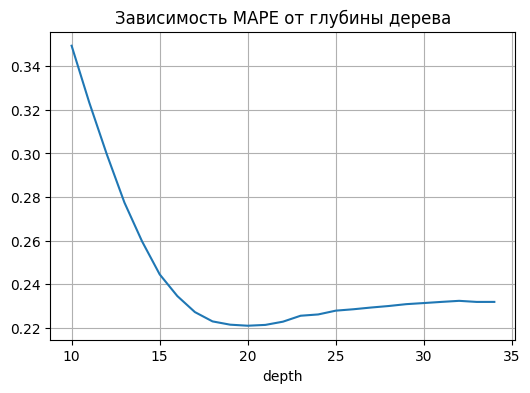

In [172]:
(pd.DataFrame(grid_dtr.cv_results_).set_index('param_max_depth')['mean_test_score']*(-1)).plot(
    grid=True,figsize=(6,4),xlabel='depth', title='Зависимость MAPE от глубины дерева',legend = None); plt.show()

In [173]:
print(f"mape_min = {-grid_dtr.best_score_:.4f} при глубине {grid_dtr.best_params_['max_depth']}")

mape_min = 0.2209 при глубине 20


### RandomForestRegressor (OE)

#### Гиперпараметры по умолчанию

In [178]:
%%time
model  = RandomForestRegressor(random_state=12345)
result = cross_validate(model,features,target,scoring='neg_mean_absolute_percentage_error', 
                        cv=KFold(shuffle=True,random_state=12345))

CPU times: total: 22min 12s
Wall time: 22min 13s


In [179]:
print(f"MAPE = {-result['test_score'].mean():.4f}")

MAPE = 0.1795


#### RandomizedSearchCV

In [180]:
model_rfr = RandomForestRegressor(random_state=12345)
parametrs = {'max_depth': range (20,35), 'n_estimators': range(20,201,20)}
grid_rfr  = RandomizedSearchCV(estimator = model_rfr, param_distributions = parametrs, random_state = 123, cv = 3, n_iter=20,
                               scoring = 'neg_mean_absolute_percentage_error')

In [181]:
%%time
grid_rfr.fit(features, target) # весь учебный датасет; закодированный OE, неотмасштабированный

CPU times: total: 3h 55min 36s
Wall time: 3h 55min 44s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
                   n_iter=20,
                   param_distributions={'max_depth': range(20, 35),
                                        'n_estimators': range(20, 201, 20)},
                   random_state=123,
                   scoring='neg_mean_absolute_percentage_error')

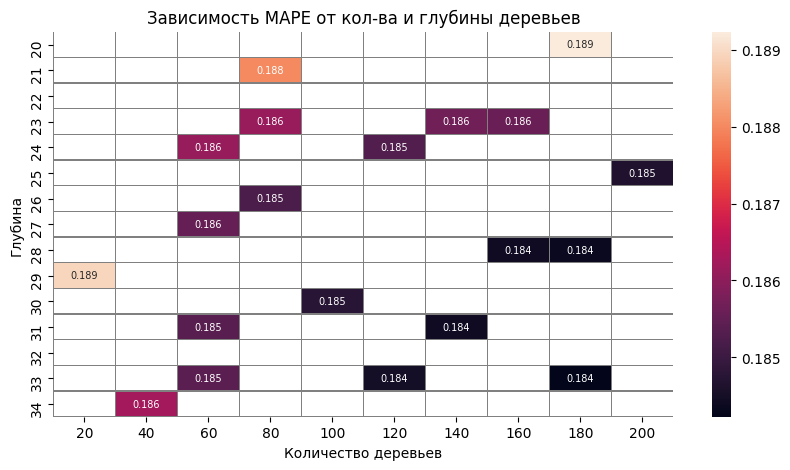

In [182]:
# создаём пустую таблицу
mape_df = pd.DataFrame(index=range(20,35),columns=range(20,201,20)).astype(float)

# заполняем таблицу расчитанной метрикой
def assignment (x): 
    mape_df.loc[x['param_max_depth'],x['param_n_estimators']] = -x['mean_test_score']
pd.DataFrame(grid_rfr.cv_results_).apply(lambda x: assignment (x), axis=1)

# выводим горячую карту
plt.figure(figsize=(10,5))
sns.heatmap(mape_df,annot=True, linewidth=0.2, linecolor='grey', fmt='.3f', annot_kws={"size":7})
plt.title('Зависимость MAPE от кол-ва и глубины деревьев'); plt.xlabel('Количество деревьев'); plt.ylabel('Глубина'); plt.show()

In [183]:
print(f"mape_min = {-grid_rfr.best_score_:.4f} при глубине {grid_rfr.best_params_['max_depth']} и\
 числе деревьев {grid_rfr.best_params_['n_estimators']}")

mape_min = 0.1842 при глубине 33 и числе деревьев 180


#### Feature importance based on mean decrease in impurity

In [185]:
grid_rfr.best_estimator_

RandomForestRegressor(max_depth=33, n_estimators=180, random_state=12345)

In [187]:
importances = grid_rfr.best_estimator_.feature_importances_

In [188]:
feature_names = features.columns
forest_importances = pd.Series(importances, index=feature_names)

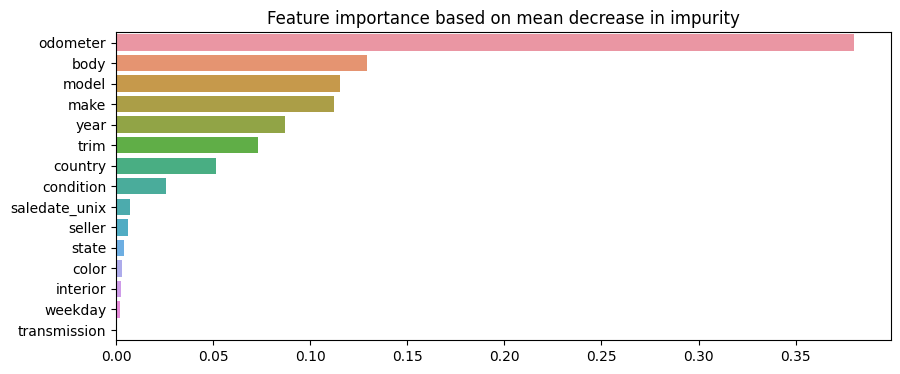

In [189]:
plt.figure(figsize=(10,4))
sns.barplot(x=forest_importances.sort_values(ascending=False),
            y=forest_importances.sort_values(ascending=False).index).set(
    title='Feature importance based on mean decrease in impurity')
plt.show()

<a id= 'feature_importance'></a>
#### Feature importance based on feature permutation

In [193]:
%%time
result = permutation_importance(grid_rfr.best_estimator_, features, target, n_repeats=5, random_state=42)

CPU times: total: 37min 17s
Wall time: 37min 24s


In [194]:
forest_importances_2 = pd.Series(result.importances_mean, index=feature_names)

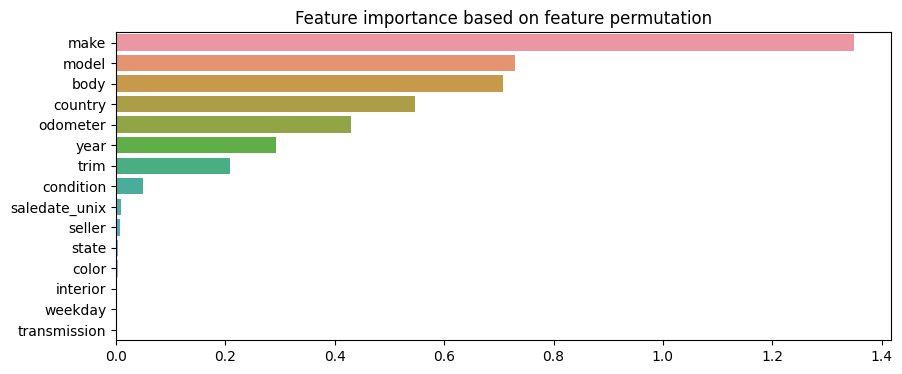

In [195]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=forest_importances_2.sort_values(ascending=False),
            y=forest_importances_2.sort_values(ascending=False).index).set(
    title='Feature importance based on feature permutation')
plt.show()

####  только самые влиятельные признаки

'make','model','body','country','year','condition','odometer','trim','month'

In [196]:
%%time
ml('RFR',ft_scaled2,tt2,fv_scaled2,tv2)

CPU times: total: 2min 32s
Wall time: 2min 32s


0.17842465953405862

### DecissionTreeRegressor (OHE)

In [197]:
ml('DTR',ft_ohe, tt, fv_ohe, tv)         # только самые влиятельные признаки; гиперпараметры по умолчанию

0.2110363591214957

### RandomForestRegressor (OHE)

Обрабатываем только самые влиятельные признаки:\
'make','model','body','country','trim', 'year', 'condition', 'odometer', 'month'

In [198]:
ml('RFR', ft_ohe, tt, fv_ohe, tv)      # гиперпараметры по умолчанию

0.16575300848347085

### Предсказание на test для Kaggle

Обучим лучшую модель RandomForestRegressor с параметрами по умолчанию на всех объектах (без разделения на train/valid):

In [209]:
ftv_ohe = pd.concat([ft_ohe, fv_ohe])      # объединение обучающих и валидационных признаков
ttv     = pd.concat([tt, tv])

In [210]:
%%time
model = RandomForestRegressor(random_state=12345)
model.fit(ftv_ohe, ttv)

CPU times: total: 52min 33s
Wall time: 52min 35s


RandomForestRegressor(random_state=12345)

In [212]:
# предсказание на тестовой выборке
prediction = model.predict(f_test_ohe)
prediction_df = pd.DataFrame(data_test['vin']).join(pd.DataFrame(prediction,data_test.index,['sellingprice']))
prediction_df.head()

vin  sellingprice
0  1g6dp567450124779       3933.00
1  1gtw7fca7e1902207      22367.00
2  jn8az1mw6dw303497      18974.00
3  2g1wf5e34d1160703       9046.01
4  1n6aa0ec3dn301209      22890.00

In [213]:
prediction_df.shape

(110060, 2)

Организаторы соревнования сообщили, что необходимо удалить 2 объекта со значительными выбросами в тестовой выборке.\
Только после этого размещать файл на площадке.

In [214]:
prediction_df.drop(data_test.query("vin in ['4s2cm58v9s4375559','1ftne2ew6eda13643']").index, inplace=True)

In [215]:
prediction_df.shape

(110058, 2)

In [216]:
# prediction_df.to_csv('nw_prediction_test_portfolio.csv',index=False) # сохранение предсказания в файл

## Вывод

**Исследование и предобработка данных** <br>
Изучено 3 датасета. Отработаны пропуски, дубликаты. Добавлены новые признаки. В некоторых категориальных признаках сокращено число уникальных значений за счёт группировки. В ряде количественных признаках изменён тип данных на менее памятизатратный. Определена взаимосвязь признаков по средствам коэффициента корреляции Пирсона и диаграмм рассеяния. <br>
Подробно [выше](#preprocessing).
<br><br>
**Machine Learning**<br>
* использованные методики кодирования: Ordinal Encoding (OE), One Hot Encoding (OHE);
* масштабирование проводилось только на ОЕ для применения в линейной модели;
* проводились эксперименты с разным числом признаков, от минимального кол-ва самых влиятельных (feature_importance) до полного списка, за исключением мультиколлинеарных;
* рейтинг влиятельности признаков на целевой признак в порядке уменьшения влияния: make, body, model, country, odometer, year, trim, condition, saledate_unix, seller, state, interior, transmission, weekday, color;
* метрика для определения качества модели - Mean Absolute Percentage Error (MAPE).
<br><br>
Сводные данные по результам ML-экспериментов: <br><br>
* LinearRegression (OE), MAPE = <font color='red'>0.6863</font>;
* DecisionTreeRegressor (OE), MAPE = <font color='red'>0.2209</font> при глубине 20;
* RandomForestRegressor (OE), гиперпараметры по умолчанию, MAPE = <font color='red'>0.1795</font>;
* RandomForestRegressor (OE), RandomizedSearchCV, MAPE = <font color='red'>0.1842</font> при глубине 33 и числе деревьев 180;
* RandomForestRegressor (OE), гиперпараметры по умолчанию, только самые влиятельные признаки, MAPE = <font color='red'>0.1784</font>;
* DecissionTreeRegressor (OHE), гиперпараметры по умолчанию, MAPE = <font color='red'>0.2110</font>;
* **RandomForestRegressor (OHE), гиперпараметры по умолчанию, только самые влиятельные признаки, MAPE = <font color='red'>0.1658</font>.** <br> (модель, показавшая лучший результат)